# Detector Model Comparison Analysis

## Comparative Evaluation of MCP Security Gateway Detection Models

**Abstract**: This notebook provides a comprehensive comparative analysis of all detection models used in the MCP Security Gateway: Rule-Based, Statistical, Semantic, MAML, and Ensemble detectors. We evaluate performance metrics, statistical significance, error patterns, prediction agreement, and computational efficiency to understand the relative strengths and weaknesses of each approach.

**Research Questions**:
1. Which detector achieves the best overall classification performance?
2. Are performance differences statistically significant?
3. Do detectors make similar or complementary errors?
4. What is the computational cost-performance trade-off?
5. Does the ensemble provide meaningful improvement over individual detectors?

---

## 1. Environment Setup

In [1]:
import sys
import json
import time
import warnings
from pathlib import Path
from typing import Dict, List, Tuple, Any, Optional
from dataclasses import dataclass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import friedmanchisquare, wilcoxon
import torch

from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report, f1_score, precision_score,
    recall_score, accuracy_score, roc_auc_score, matthews_corrcoef,
    balanced_accuracy_score, cohen_kappa_score
)
from sklearn.utils import resample

warnings.filterwarnings('ignore')

# Add project root to path
PROJECT_ROOT = Path.cwd().parent.parent
sys.path.insert(0, str(PROJECT_ROOT / 'mcp_bridge' / 'src'))

print(f"Project root: {PROJECT_ROOT}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Project root: w:\__Projects__\MCP-Security-Gateway
PyTorch version: 2.9.1+cu130
CUDA available: True


In [2]:
# === VISUALIZATION CONFIGURATION ===
# Colorblind-friendly palette (Wong, 2011 - Nature Methods)

COLORS = {
    # Class colors
    'benign': '#009E73',       # Bluish green
    'attack': '#D55E00',       # Vermillion
    # Detector colors
    'rule_based': '#0072B2',   # Blue
    'statistical': '#56B4E9',  # Sky blue
    'semantic': '#F0E442',     # Yellow
    'maml': '#CC79A7',         # Reddish purple
    'ensemble': '#000000',     # Black
}

DETECTOR_ORDER = ['rule_based', 'statistical', 'semantic', 'maml', 'ensemble']
DETECTOR_LABELS = {
    'rule_based': 'Rule-Based',
    'statistical': 'Statistical',
    'semantic': 'Semantic',
    'maml': 'MAML',
    'ensemble': 'Ensemble'
}

# IEEE-style plot configuration
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 10,
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.titlesize': 14,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.spines.top': False,
    'axes.spines.right': False,
})

# Set random seed for reproducibility
np.random.seed(seed=42)
torch.manual_seed(seed=42)

print("Visualization configuration loaded.")

Visualization configuration loaded.


## 2. Data Loading

In [3]:
def load_dataset(path: Path) -> Tuple[List[Dict], List[int], List[str]]:
    """Load dataset and extract samples with labels."""
    with open(path, 'r') as f:
        data = json.load(f)
    
    # Remove metadata if present
    data.pop('_metadata', None)
    
    samples = []
    labels = []
    tools = []
    
    for tool_name, tool_data in data.items():
        # Benign samples (label=0)
        for sample in tool_data.get('benign', []):
            samples.append({'tool': tool_name, 'payload': sample})
            labels.append(0)
            tools.append(tool_name)
        
        # Attack samples (label=1)
        for sample in tool_data.get('attack', []):
            samples.append({'tool': tool_name, 'payload': sample})
            labels.append(1)
            tools.append(tool_name)
    
    return samples, labels, tools

# Load datasets
DATA_DIR = PROJECT_ROOT / 'research' / 'data'
MODELS_DIR = PROJECT_ROOT / 'research' / 'trained_models'

# Create figures directory
FIGURES_DIR = Path('figures')
FIGURES_DIR.mkdir(exist_ok=True)

train_samples, train_labels, train_tools = load_dataset(DATA_DIR / 'owasp_training_dataset.json')
test_samples, test_labels, test_tools = load_dataset(DATA_DIR / 'owasp_test_dataset.json')

print(f"Training set: {len(train_samples)} samples")
print(f"  - Benign: {sum(1 for l in train_labels if l == 0)}")
print(f"  - Attack: {sum(1 for l in train_labels if l == 1)}")
print(f"\nTest set: {len(test_samples)} samples")
print(f"  - Benign: {sum(1 for l in test_labels if l == 0)}")
print(f"  - Attack: {sum(1 for l in test_labels if l == 1)}")
print(f"\nUnique tools: {len(set(test_tools))}")

Training set: 1186 samples
  - Benign: 593
  - Attack: 593

Test set: 2328 samples
  - Benign: 2088
  - Attack: 240

Unique tools: 32


## 3. Model Loading and Initialization

In [4]:
from core.detectors.rule_based import RuleBasedDetector
from core.detectors.statistical import StatisticalFeatureDetector
from core.detectors.semantic import SemanticDetector
from core.detectors.maml import MAMLDetector, MAMLConfig

# Initialize detectors
detectors = {}

# Rule-based (no training needed)
detectors['rule_based'] = RuleBasedDetector()
print("[✓] Rule-Based detector initialized")

# Statistical detector
detectors['statistical'] = StatisticalFeatureDetector(sigma=3.0)
stat_model_path = MODELS_DIR / 'statistical_model.pt'
if stat_model_path.exists():
    state = torch.load(stat_model_path, map_location='cpu', weights_only=False)
    detectors['statistical'].load_state(state)
    print(f"[✓] Statistical detector loaded from checkpoint ({len(detectors['statistical'].class_stats)} tools)")
else:
    print("[!] Statistical model not found - training required")

# Semantic detector
detectors['semantic'] = SemanticDetector(model_name="distilbert-base-uncased", sigma=3.0)
sem_model_path = MODELS_DIR / 'semantic_model.pt'
if sem_model_path.exists():
    state = torch.load(sem_model_path, map_location='cpu', weights_only=False)
    detectors['semantic'].load_state(state)
    print(f"[✓] Semantic detector loaded from checkpoint ({len(detectors['semantic'].prototypes)} tools)")
else:
    print("[!] Semantic model not found - training required")

# MAML detector
maml_config = MAMLConfig(
    meta_lr=0.001,
    inner_lr=0.01,
    adaptation_steps=5,
    first_order=True
)
detectors['maml'] = MAMLDetector(model_name="distilbert-base-uncased", config=maml_config)
maml_model_path = MODELS_DIR / 'maml_model.pt'
if maml_model_path.exists():
    state = torch.load(maml_model_path, map_location='cpu', weights_only=False)
    detectors['maml'].load_state(state)
    print(f"[✓] MAML detector loaded from checkpoint ({len(detectors['maml'].adapted_models)} tools)")
else:
    print("[!] MAML model not found - will use untrained")

print(f"\nTotal detectors loaded: {len(detectors)}")

[✓] Rule-Based detector initialized
[✓] Statistical detector loaded from checkpoint (32 tools)
[✓] Semantic detector loaded from checkpoint (32 tools)
[✓] MAML detector loaded from checkpoint (32 tools)

Total detectors loaded: 4


In [5]:
# Train detectors if needed (on training data)
def prepare_training_data(samples, labels):
    """Prepare training data in detector-compatible format."""
    tool_data = {}
    for sample, label in zip(samples, labels):
        tool = sample['tool']
        if tool not in tool_data:
            tool_data[tool] = {'benign': [], 'attack': []}
        
        key = 'benign' if label == 0 else 'attack'
        tool_data[tool][key].append(sample['payload'])
    
    return tool_data

training_data = prepare_training_data(train_samples, train_labels)

# Fit detectors that need training
if not stat_model_path.exists():
    print("Training Statistical detector...")
    detectors['statistical'].fit(training_data)
    
if not sem_model_path.exists():
    print("Training Semantic detector...")
    detectors['semantic'].fit(training_data)

print("All detectors ready.")

All detectors ready.


## 4. Generate Predictions from All Detectors

In [6]:
@dataclass
class DetectorResult:
    """Container for detector prediction results."""
    predictions: np.ndarray      # Binary predictions (0=benign, 1=attack)
    probabilities: np.ndarray    # Attack probability scores
    latencies: np.ndarray        # Inference time per sample (ms)

def get_predictions(detector, samples: List[Dict], detector_name: str) -> DetectorResult:
    """Get predictions from a detector with timing."""
    predictions = []
    probabilities = []
    latencies = []
    
    for sample in samples:
        tool = sample['tool']
        payload = sample['payload']
        
        start_time = time.perf_counter()
        
        # Different detectors have different signatures
        if detector_name == 'rule_based':
            result = detector.predict(payload)
        else:
            result = detector.predict(payload, tool)
        
        elapsed = (time.perf_counter() - start_time) * 1000  # ms
        latencies.append(elapsed)
        
        if result is None:
            # Rule-based returns None when no pattern matches
            predictions.append(0)  # Default to benign
            probabilities.append(0.5)  # Uncertain
        else:
            # Result object has .classification and .confidence attributes
            pred_class = result.classification
            confidence = result.confidence
            
            # Convert to binary: ATTACK=1, BENIGN=0
            is_attack = 1 if pred_class.lower() == 'attack' else 0
            predictions.append(is_attack)
            
            # Convert confidence to attack probability
            if is_attack:
                probabilities.append(confidence)
            else:
                probabilities.append(1 - confidence)
    
    return DetectorResult(
        predictions=np.array(predictions),
        probabilities=np.array(probabilities),
        latencies=np.array(latencies)
    )

# Collect predictions from all detectors
print("Generating predictions from all detectors...")
print("(This may take a few minutes for semantic/MAML detectors)\n")

results = {}
for name, detector in detectors.items():
    print(f"  Processing {DETECTOR_LABELS[name]}...", end=' ', flush=True)
    results[name] = get_predictions(detector, test_samples, name)
    print(f"Done ({results[name].latencies.mean():.2f} ms/sample avg)")

print("\nAll predictions collected.")

Generating predictions from all detectors...
(This may take a few minutes for semantic/MAML detectors)

  Processing Rule-Based... 

Done (0.03 ms/sample avg)
  Processing Statistical... Done (0.06 ms/sample avg)
  Processing Semantic... Done (17.75 ms/sample avg)
  Processing MAML... Done (6.94 ms/sample avg)

All predictions collected.


In [7]:
# Generate ensemble predictions using weighted voting
ENSEMBLE_WEIGHTS = {
    'rule_based': 0.40,
    'statistical': 0.15,
    'semantic': 0.35,
    'maml': 0.10
}

MARGIN_THRESHOLD = 0.10  # 10% margin for fail-safe

def compute_ensemble_predictions(results: Dict[str, DetectorResult]) -> DetectorResult:
    """Compute ensemble predictions using weighted voting."""
    n_samples = len(results['rule_based'].predictions)
    
    ensemble_probs = np.zeros(n_samples)
    ensemble_preds = np.zeros(n_samples, dtype=int)
    ensemble_latencies = np.zeros(n_samples)
    
    for i in range(n_samples):
        weighted_attack_score = 0.0
        weighted_benign_score = 0.0
        total_latency = 0.0
        
        for det_name, weight in ENSEMBLE_WEIGHTS.items():
            if det_name in results:
                prob = results[det_name].probabilities[i]
                weighted_attack_score += weight * prob
                weighted_benign_score += weight * (1 - prob)
                total_latency += results[det_name].latencies[i]
        
        # Normalize
        total_weight = sum(ENSEMBLE_WEIGHTS.values())
        attack_prob = weighted_attack_score / total_weight
        benign_prob = weighted_benign_score / total_weight
        
        # Margin-based decision with fail-safe
        margin = benign_prob - attack_prob
        if margin > MARGIN_THRESHOLD:
            ensemble_preds[i] = 0  # Benign
        else:
            ensemble_preds[i] = 1  # Attack (fail-safe)
        
        ensemble_probs[i] = attack_prob
        ensemble_latencies[i] = total_latency
    
    return DetectorResult(
        predictions=ensemble_preds,
        probabilities=ensemble_probs,
        latencies=ensemble_latencies
    )

results['ensemble'] = compute_ensemble_predictions(results)
print(f"Ensemble predictions computed ({results['ensemble'].latencies.mean():.2f} ms/sample avg)")

Ensemble predictions computed (24.79 ms/sample avg)


---

## 5. Performance Metrics Comparison

### 5.1 Core Metrics Summary

In [8]:
def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray, y_prob: np.ndarray) -> Dict[str, float]:
    """Compute comprehensive classification metrics."""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'balanced_accuracy': balanced_accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'specificity': recall_score(y_true, y_pred, pos_label=0, zero_division=0),
        'mcc': matthews_corrcoef(y_true, y_pred),
        'cohen_kappa': cohen_kappa_score(y_true, y_pred),
    }
    
    # ROC-AUC (requires probability scores)
    try:
        metrics['roc_auc'] = roc_auc_score(y_true, y_prob)
    except ValueError:
        metrics['roc_auc'] = np.nan
    
    # Average Precision
    try:
        metrics['avg_precision'] = average_precision_score(y_true, y_prob)
    except ValueError:
        metrics['avg_precision'] = np.nan
    
    return metrics

# Compute metrics for all detectors
y_true = np.array(test_labels)
all_metrics = {}

for name in DETECTOR_ORDER:
    if name in results:
        all_metrics[name] = compute_metrics(
            y_true, 
            results[name].predictions, 
            results[name].probabilities
        )

# Create comparison DataFrame
metrics_df = pd.DataFrame(all_metrics).T
metrics_df.index = [DETECTOR_LABELS[n] for n in metrics_df.index]

# Display formatted table
print("=" * 80)
print("DETECTOR PERFORMANCE COMPARISON")
print("=" * 80)
display(metrics_df.round(4).style.background_gradient(cmap='RdYlGn', axis=0))

DETECTOR PERFORMANCE COMPARISON


,accuracy,balanced_accuracy,precision,recall,f1,specificity,mcc,cohen_kappa,roc_auc,avg_precision
Rule-Based,0.916700,0.745200,0.610600,0.529200,0.567000,0.961200,0.522800,0.521100,0.745200,0.371600
Statistical,0.540800,0.731100,0.179900,0.970800,0.303600,0.491400,0.282900,0.156900,0.850400,0.293800
Semantic,0.809300,0.862300,0.343100,0.929200,0.501100,0.795500,0.491200,0.412700,0.918800,0.504700
MAML,0.324700,0.586700,0.124200,0.916700,0.218700,0.256700,0.123600,0.045300,0.761900,0.521800
Ensemble,0.715200,0.830200,0.262600,0.975000,0.413800,0.685300,0.413100,0.300100,0.956500,0.795400


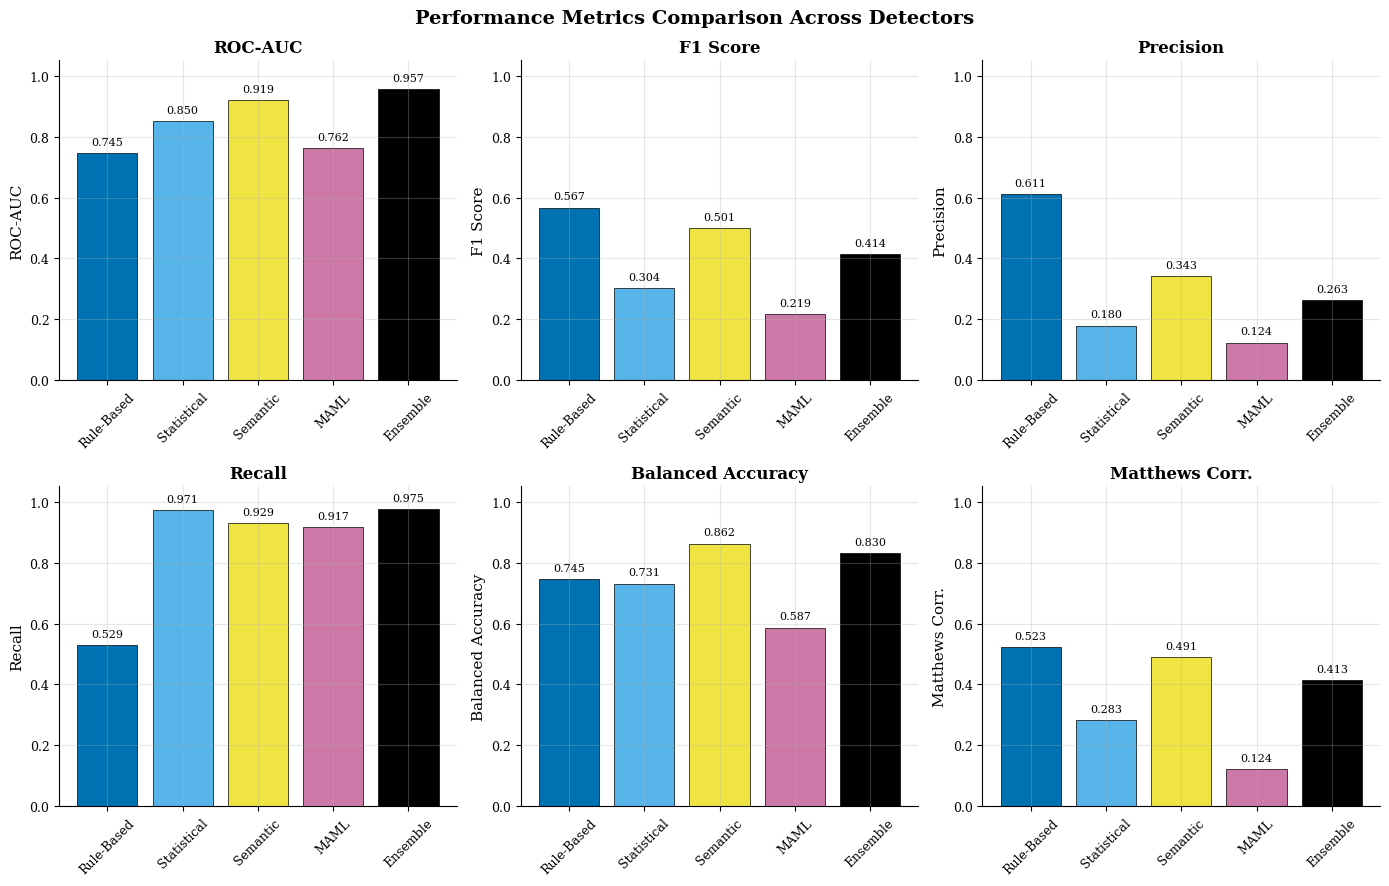

In [9]:
# Visualize key metrics comparison
fig, axes = plt.subplots(2, 3, figsize=(14, 9))

key_metrics = ['roc_auc', 'f1', 'precision', 'recall', 'balanced_accuracy', 'mcc']
metric_titles = ['ROC-AUC', 'F1 Score', 'Precision', 'Recall', 'Balanced Accuracy', 'Matthews Corr.']

for ax, metric, title in zip(axes.flat, key_metrics, metric_titles):
    values = [all_metrics[name][metric] for name in DETECTOR_ORDER if name in all_metrics]
    colors = [COLORS[name] for name in DETECTOR_ORDER if name in all_metrics]
    labels = [DETECTOR_LABELS[name] for name in DETECTOR_ORDER if name in all_metrics]
    
    bars = ax.bar(labels, values, color=colors, edgecolor='black', linewidth=0.5)
    ax.set_ylabel(title)
    ax.set_ylim(0, 1.05)
    ax.set_title(title, fontweight='bold')
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{val:.3f}', ha='center', va='bottom', fontsize=8)
    
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('Performance Metrics Comparison Across Detectors', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../figures/metrics_comparison_bars.png', dpi=600, bbox_inches='tight')
plt.show()

### 5.2 ROC Curve Comparison

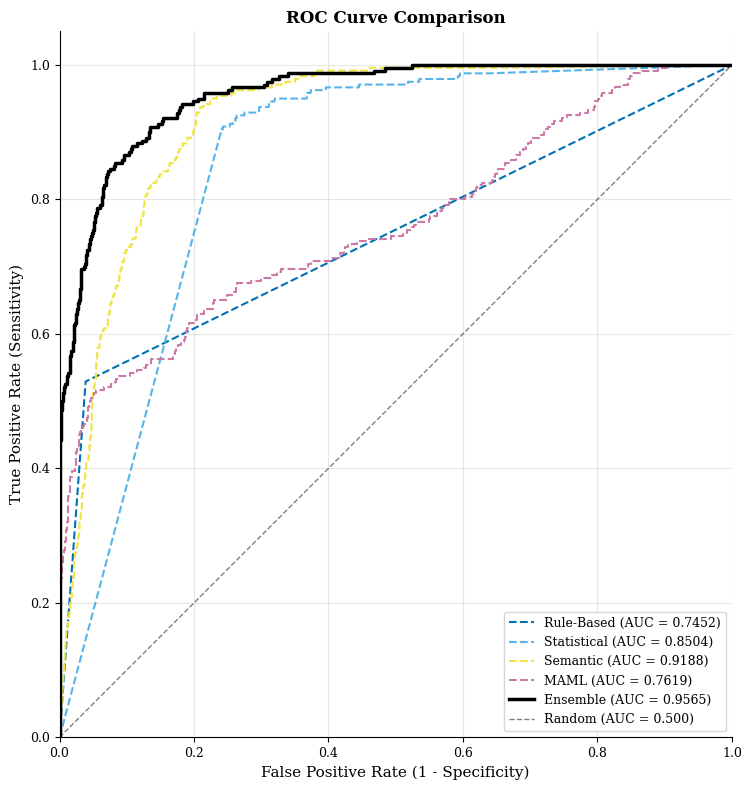

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot ROC curve for each detector
for name in DETECTOR_ORDER:
    if name not in results:
        continue
    
    fpr, tpr, _ = roc_curve(y_true, results[name].probabilities)
    roc_auc = auc(fpr, tpr)
    
    linewidth = 2.5 if name == 'ensemble' else 1.5
    linestyle = '-' if name == 'ensemble' else '--'
    
    ax.plot(fpr, tpr, 
            color=COLORS[name], 
            linewidth=linewidth,
            linestyle=linestyle,
            label=f'{DETECTOR_LABELS[name]} (AUC = {roc_auc:.4f})')

# Diagonal reference line
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5, label='Random (AUC = 0.500)')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate (1 - Specificity)')
ax.set_ylabel('True Positive Rate (Sensitivity)')
ax.set_title('ROC Curve Comparison', fontweight='bold')
ax.legend(loc='lower right')
ax.set_aspect('equal')

plt.tight_layout()
plt.savefig('../figures/roc_comparison.png', dpi=600, bbox_inches='tight')
plt.show()

### 5.3 Precision-Recall Curve Comparison

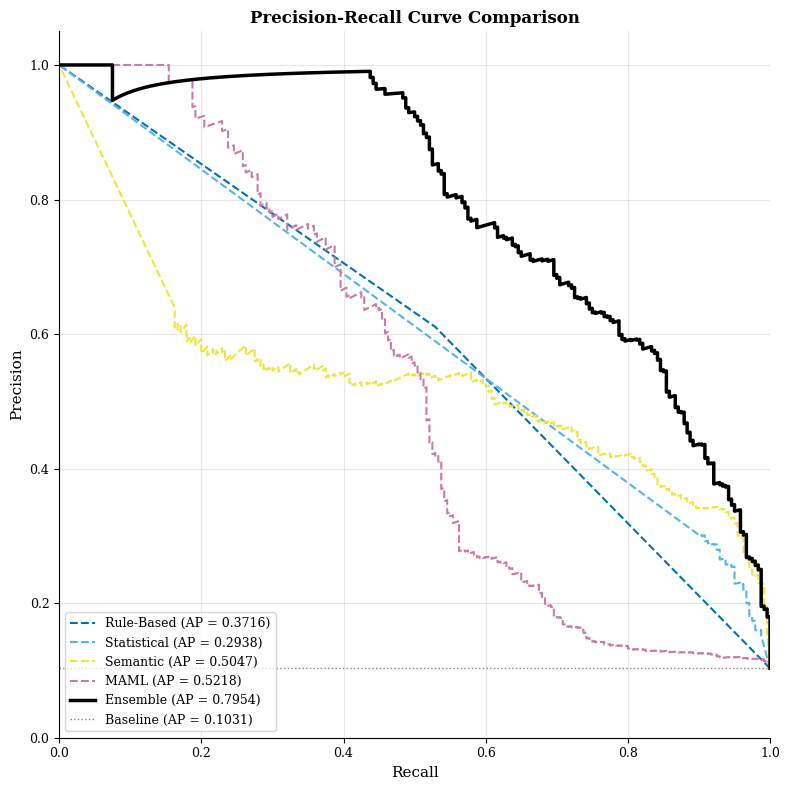

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot PR curve for each detector
for name in DETECTOR_ORDER:
    if name not in results:
        continue
    
    precision, recall, _ = precision_recall_curve(y_true, results[name].probabilities)
    ap = average_precision_score(y_true, results[name].probabilities)
    
    linewidth = 2.5 if name == 'ensemble' else 1.5
    linestyle = '-' if name == 'ensemble' else '--'
    
    ax.plot(recall, precision,
            color=COLORS[name],
            linewidth=linewidth,
            linestyle=linestyle,
            label=f'{DETECTOR_LABELS[name]} (AP = {ap:.4f})')

# Baseline (random classifier)
baseline = sum(y_true) / len(y_true)
ax.axhline(y=baseline, color='gray', linestyle=':', linewidth=1, 
           label=f'Baseline (AP = {baseline:.4f})')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve Comparison', fontweight='bold')
ax.legend(loc='lower left')

plt.tight_layout()
plt.savefig('../figures/pr_comparison.png', dpi=600, bbox_inches='tight')
plt.show()

### 5.4 Confusion Matrices Comparison

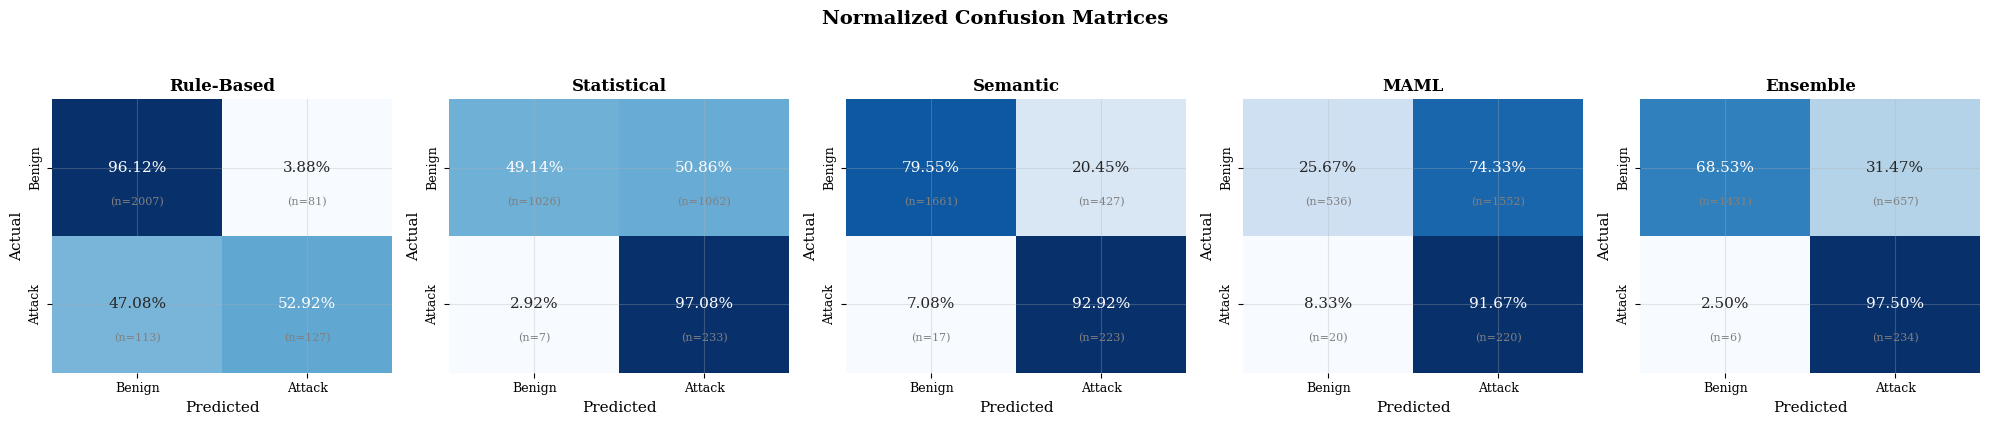

In [12]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for ax, name in zip(axes, DETECTOR_ORDER):
    if name not in results:
        ax.set_visible(False)
        continue
    
    cm = confusion_matrix(y_true, results[name].predictions)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=['Benign', 'Attack'],
                yticklabels=['Benign', 'Attack'],
                ax=ax, cbar=False,
                annot_kws={'size': 11})
    
    # Add raw counts
    for i in range(2):
        for j in range(2):
            ax.text(j + 0.5, i + 0.75, f'(n={cm[i,j]})',
                    ha='center', va='center', fontsize=8, color='gray')
    
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'{DETECTOR_LABELS[name]}', fontweight='bold')

plt.suptitle('Normalized Confusion Matrices', fontsize=14, fontweight='bold', y=1.05)
plt.tight_layout()
plt.savefig('../figures/confusion_matrices_comparison.png', dpi=600, bbox_inches='tight')
plt.show()

---

## 6. Statistical Significance Testing

### 6.1 McNemar's Test (Pairwise Comparison)

In [13]:
def mcnemar_test(y_true: np.ndarray, pred_a: np.ndarray, pred_b: np.ndarray) -> Tuple[float, float]:
    """Perform McNemar's test comparing two classifiers.
    
    Returns chi-squared statistic and p-value.
    Tests whether the disagreements between classifiers are symmetric.
    """
    # Build contingency table of disagreements
    correct_a = (pred_a == y_true)
    correct_b = (pred_b == y_true)
    
    # b: A correct, B wrong; c: A wrong, B correct
    b = np.sum(correct_a & ~correct_b)  # A right, B wrong
    c = np.sum(~correct_a & correct_b)  # A wrong, B right
    
    # McNemar's test with continuity correction
    if b + c == 0:
        return 0.0, 1.0  # No disagreements
    
    chi2 = (abs(b - c) - 1) ** 2 / (b + c)
    p_value = 1 - stats.chi2.cdf(chi2, df=1)
    
    return chi2, p_value

# Pairwise McNemar's tests
detector_names = [n for n in DETECTOR_ORDER if n in results]
n_detectors = len(detector_names)

mcnemar_matrix = np.ones((n_detectors, n_detectors))
chi2_matrix = np.zeros((n_detectors, n_detectors))

print("McNemar's Test Results (p-values)")
print("=" * 60)
print(f"{'Comparison':<30} {'χ²':>10} {'p-value':>12} {'Sig.':>6}")
print("-" * 60)

for i, name_a in enumerate(detector_names):
    for j, name_b in enumerate(detector_names):
        if i < j:
            chi2, p_val = mcnemar_test(
                y_true,
                results[name_a].predictions,
                results[name_b].predictions
            )
            mcnemar_matrix[i, j] = p_val
            mcnemar_matrix[j, i] = p_val
            chi2_matrix[i, j] = chi2
            chi2_matrix[j, i] = chi2
            
            sig = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else ''
            comparison = f"{DETECTOR_LABELS[name_a]} vs {DETECTOR_LABELS[name_b]}"
            print(f"{comparison:<30} {chi2:>10.3f} {p_val:>12.4f} {sig:>6}")

print("-" * 60)
print("Significance: * p<0.05, ** p<0.01, *** p<0.001")

McNemar's Test Results (p-values)
Comparison                             χ²      p-value   Sig.
------------------------------------------------------------
Rule-Based vs Statistical         667.141       0.0000    ***
Rule-Based vs Semantic            102.992       0.0000    ***
Rule-Based vs MAML               1200.082       0.0000    ***
Rule-Based vs Ensemble            308.920       0.0000    ***
Statistical vs Semantic           510.322       0.0000    ***
Statistical vs MAML               287.348       0.0000    ***
Statistical vs Ensemble           302.629       0.0000    ***
Semantic vs MAML                 1047.961       0.0000    ***
Semantic vs Ensemble              192.405       0.0000    ***
MAML vs Ensemble                  784.457       0.0000    ***
------------------------------------------------------------
Significance: * p<0.05, ** p<0.01, *** p<0.001


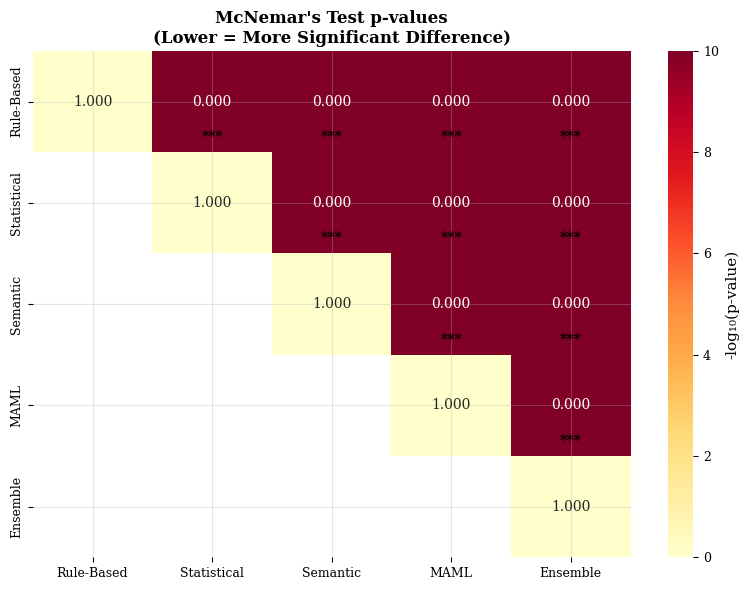

In [14]:
# Visualize McNemar p-value matrix
fig, ax = plt.subplots(figsize=(8, 6))

# Use -log10(p) for visualization (higher = more significant)
log_p_matrix = -np.log10(mcnemar_matrix + 1e-10)
np.fill_diagonal(log_p_matrix, 0)

labels = [DETECTOR_LABELS[n] for n in detector_names]

mask = np.triu(np.ones_like(mcnemar_matrix, dtype=bool), k=1)

sns.heatmap(log_p_matrix, annot=mcnemar_matrix, fmt='.3f', 
            xticklabels=labels, yticklabels=labels,
            cmap='YlOrRd', ax=ax, mask=mask.T,
            cbar_kws={'label': '-log₁₀(p-value)'})

# Add significance markers
for i in range(n_detectors):
    for j in range(i + 1, n_detectors):
        p_val = mcnemar_matrix[i, j]
        if p_val < 0.001:
            marker = '***'
        elif p_val < 0.01:
            marker = '**'
        elif p_val < 0.05:
            marker = '*'
        else:
            marker = ''
        if marker:
            ax.text(j + 0.5, i + 0.85, marker, ha='center', va='center', 
                    fontsize=10, fontweight='bold', color='black')

ax.set_title("McNemar's Test p-values\n(Lower = More Significant Difference)", fontweight='bold')
plt.tight_layout()
plt.savefig('../figures/mcnemar_heatmap.png', dpi=600, bbox_inches='tight')
plt.show()

### 6.2 Bootstrap Confidence Intervals

In [15]:
def bootstrap_metric(y_true: np.ndarray, y_pred: np.ndarray, y_prob: np.ndarray,
                     metric_fn, n_bootstrap: int = 1000, ci: float = 0.95) -> Tuple[float, float, float]:
    """Compute bootstrap confidence interval for a metric."""
    scores = []
    n_samples = len(y_true)
    
    for _ in range(n_bootstrap):
        # Stratified resampling
        indices = resample(range(n_samples), n_samples=n_samples, stratify=y_true)
        
        try:
            if metric_fn.__name__ in ['roc_auc_score', 'average_precision_score']:
                score = metric_fn(y_true[indices], y_prob[indices])
            else:
                score = metric_fn(y_true[indices], y_pred[indices])
            scores.append(score)
        except ValueError:
            continue
    
    if not scores:
        return np.nan, np.nan, np.nan
    
    scores = np.array(scores)
    alpha = (1 - ci) / 2
    
    return (
        np.mean(scores),
        np.percentile(scores, alpha * 100),
        np.percentile(scores, (1 - alpha) * 100)
    )

# Compute bootstrap CIs for key metrics
print("Computing bootstrap confidence intervals (n=1000)...")
print("This may take a minute...\n")

bootstrap_results = {}
metrics_to_bootstrap = [
    ('ROC-AUC', roc_auc_score),
    ('F1', f1_score),
    ('Precision', precision_score),
    ('Recall', recall_score)
]

for name in detector_names:
    bootstrap_results[name] = {}
    for metric_name, metric_fn in metrics_to_bootstrap:
        mean, ci_low, ci_high = bootstrap_metric(
            y_true,
            results[name].predictions,
            results[name].probabilities,
            metric_fn
        )
        bootstrap_results[name][metric_name] = (mean, ci_low, ci_high)

# Display results
print("Bootstrap 95% Confidence Intervals")
print("=" * 70)
for name in detector_names:
    print(f"\n{DETECTOR_LABELS[name]}:")
    for metric_name, _ in metrics_to_bootstrap:
        mean, ci_low, ci_high = bootstrap_results[name][metric_name]
        print(f"  {metric_name:<12}: {mean:.4f} [{ci_low:.4f}, {ci_high:.4f}]")

Computing bootstrap confidence intervals (n=1000)...
This may take a minute...

Bootstrap 95% Confidence Intervals

Rule-Based:
  ROC-AUC     : 0.7449 [0.7146, 0.7741]
  F1          : 0.5670 [0.5144, 0.6175]
  Precision   : 0.6109 [0.5524, 0.6685]
  Recall      : 0.5281 [0.4667, 0.5875]

Statistical:
  ROC-AUC     : 0.8501 [0.8327, 0.8658]
  F1          : 0.3036 [0.2937, 0.3136]
  Precision   : 0.1799 [0.1735, 0.1872]
  Recall      : 0.9708 [0.9500, 0.9917]

Semantic:
  ROC-AUC     : 0.9186 [0.9036, 0.9317]
  F1          : 0.5013 [0.4768, 0.5274]
  Precision   : 0.3435 [0.3233, 0.3642]
  Recall      : 0.9296 [0.8958, 0.9583]

MAML:
  ROC-AUC     : 0.7629 [0.7254, 0.8009]
  F1          : 0.2185 [0.2100, 0.2261]
  Precision   : 0.1240 [0.1186, 0.1291]
  Recall      : 0.9169 [0.8792, 0.9500]

Ensemble:
  ROC-AUC     : 0.9564 [0.9438, 0.9672]
  F1          : 0.4139 [0.3976, 0.4301]
  Precision   : 0.2630 [0.2500, 0.2763]
  Recall      : 0.9748 [0.9542, 0.9917]


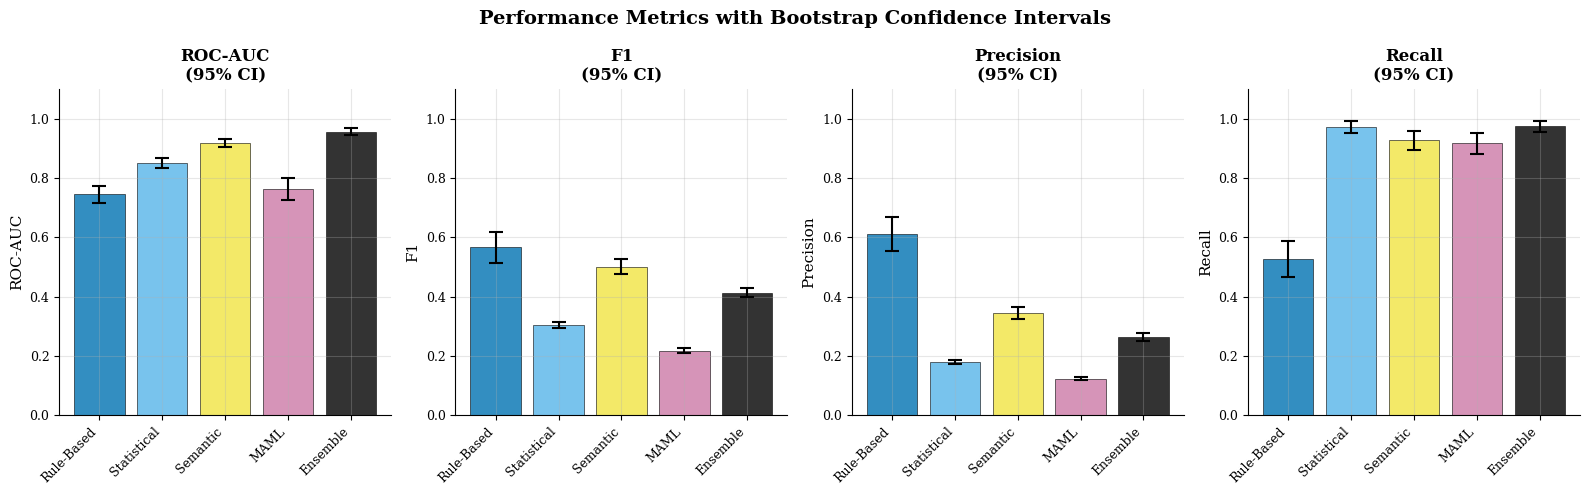

In [16]:
# Visualize confidence intervals
fig, axes = plt.subplots(1, 4, figsize=(16, 5))

for ax, (metric_name, _) in zip(axes, metrics_to_bootstrap):
    means = []
    ci_lows = []
    ci_highs = []
    
    for name in detector_names:
        mean, ci_low, ci_high = bootstrap_results[name][metric_name]
        means.append(mean)
        ci_lows.append(mean - ci_low)
        ci_highs.append(ci_high - mean)
    
    colors = [COLORS[n] for n in detector_names]
    labels = [DETECTOR_LABELS[n] for n in detector_names]
    x = np.arange(len(detector_names))
    
    ax.bar(x, means, color=colors, edgecolor='black', linewidth=0.5, alpha=0.8)
    ax.errorbar(x, means, yerr=[np.abs(ci_lows), np.abs(ci_highs)], fmt='none', 
                color='black', capsize=5, capthick=1.5)
    
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name}\n(95% CI)', fontweight='bold')
    ax.set_ylim(0, 1.1)

plt.suptitle('Performance Metrics with Bootstrap Confidence Intervals', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../figures/bootstrap_ci_comparison.png', dpi=600, bbox_inches='tight')
plt.show()

### 6.3 Friedman Test (Multi-Model Ranking)

In [17]:
# For Friedman test, we need per-sample "scores" for each model
# We'll use correctness (1 if correct, 0 if wrong) as the score

correctness = {}
for name in detector_names:
    correctness[name] = (results[name].predictions == y_true).astype(int)

# Friedman test
correctness_matrix = np.column_stack([correctness[n] for n in detector_names])
stat, p_value = friedmanchisquare(*[correctness_matrix[:, i] for i in range(len(detector_names))])

print("Friedman Test (Ranking of Classifiers)")
print("=" * 50)
print(f"χ² statistic: {stat:.4f}")
print(f"p-value: {p_value:.6f}")
print(f"Significant (α=0.05): {'Yes' if p_value < 0.05 else 'No'}")

# Compute mean ranks
ranks = np.zeros((len(y_true), len(detector_names)))
for i in range(len(y_true)):
    sample_scores = correctness_matrix[i, :]
    # Rank (1 = best, handle ties by average)
    ranks[i, :] = stats.rankdata(-sample_scores, method='average')

mean_ranks = ranks.mean(axis=0)

print(f"\nMean Ranks (lower is better):")
for name, rank in sorted(zip(detector_names, mean_ranks), key=lambda x: x[1]):
    print(f"  {DETECTOR_LABELS[name]:<15}: {rank:.3f}")

Friedman Test (Ranking of Classifiers)
χ² statistic: 2704.8882
p-value: 0.000000
Significant (α=0.05): Yes

Mean Ranks (lower is better):
  Rule-Based     : 2.362
  Semantic       : 2.630
  Ensemble       : 2.865
  Statistical    : 3.301
  MAML           : 3.841


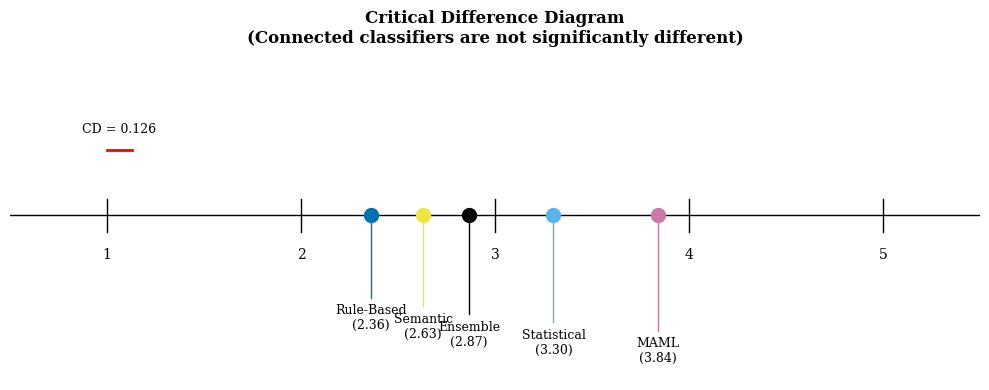


Nemenyi Critical Difference: 0.1264


In [18]:
# Critical Difference Diagram
def critical_difference_diagram(mean_ranks: np.ndarray, names: List[str], 
                                n_samples: int, alpha: float = 0.05):
    """Create a critical difference diagram."""
    k = len(names)  # number of classifiers
    
    # Nemenyi critical difference
    q_alpha = {3: 2.343, 4: 2.569, 5: 2.728, 6: 2.850, 7: 2.949, 8: 3.031}
    if k not in q_alpha:
        q = 2.728  # default for k=5
    else:
        q = q_alpha[k]
    
    cd = q * np.sqrt(k * (k + 1) / (6 * n_samples))
    
    # Sort by rank
    sorted_indices = np.argsort(mean_ranks)
    sorted_names = [names[i] for i in sorted_indices]
    sorted_ranks = mean_ranks[sorted_indices]
    
    fig, ax = plt.subplots(figsize=(10, 4))
    
    # Draw axis
    ax.set_xlim(0.5, k + 0.5)
    ax.set_ylim(0, 1)
    ax.axhline(0.5, color='black', linewidth=1)
    
    # Tick marks
    for i in range(1, k + 1):
        ax.axvline(i, ymin=0.45, ymax=0.55, color='black', linewidth=1)
        ax.text(i, 0.4, str(i), ha='center', va='top', fontsize=10)
    
    # CD bar
    cd_start = 1
    ax.plot([cd_start, cd_start + cd], [0.7, 0.7], color='red', linewidth=2)
    ax.text(cd_start + cd/2, 0.75, f'CD = {cd:.3f}', ha='center', fontsize=9)
    
    # Plot classifiers
    y_positions = np.linspace(0.25, 0.15, k)
    
    for i, (name, rank) in enumerate(zip(sorted_names, sorted_ranks)):
        color = COLORS.get(name, 'gray')
        ax.plot(rank, 0.5, 'o', markersize=10, color=color)
        ax.plot([rank, rank], [0.5, y_positions[i]], color=color, linewidth=1)
        ax.text(rank, y_positions[i] - 0.02, f'{DETECTOR_LABELS[name]}\n({rank:.2f})', 
                ha='center', va='top', fontsize=9)
    
    # Draw lines connecting classifiers not significantly different
    for i in range(k):
        for j in range(i + 1, k):
            if abs(sorted_ranks[i] - sorted_ranks[j]) < cd:
                y_bar = 0.55 + 0.05 * (j - i)
                ax.plot([sorted_ranks[i], sorted_ranks[j]], [y_bar, y_bar], 
                        color='gray', linewidth=2, alpha=0.5)
    
    ax.set_xlabel('Average Rank')
    ax.set_title('Critical Difference Diagram\n(Connected classifiers are not significantly different)',
                 fontweight='bold')
    ax.axis('off')
    
    return fig, cd

fig, cd = critical_difference_diagram(mean_ranks, detector_names, len(y_true))
plt.tight_layout()
plt.savefig('../figures/critical_difference.png', dpi=600, bbox_inches='tight')
plt.show()

print(f"\nNemenyi Critical Difference: {cd:.4f}")

---

## 7. Error Analysis

### 7.1 Error Overlap Analysis

In [19]:
# Identify errors for each detector
errors = {}
for name in detector_names:
    errors[name] = set(np.where(results[name].predictions != y_true)[0])

print("Error Counts by Detector")
print("=" * 40)
for name in detector_names:
    print(f"{DETECTOR_LABELS[name]:<15}: {len(errors[name]):>5} errors ({len(errors[name])/len(y_true)*100:.1f}%)")

# Error overlap matrix
overlap_matrix = np.zeros((len(detector_names), len(detector_names)))

for i, name_a in enumerate(detector_names):
    for j, name_b in enumerate(detector_names):
        if i == j:
            overlap_matrix[i, j] = len(errors[name_a])
        else:
            overlap_matrix[i, j] = len(errors[name_a] & errors[name_b])

print("\nError Overlap Matrix (count of shared errors):")
overlap_df = pd.DataFrame(overlap_matrix, 
                          index=[DETECTOR_LABELS[n] for n in detector_names],
                          columns=[DETECTOR_LABELS[n] for n in detector_names])
display(overlap_df.astype(int))

Error Counts by Detector
Rule-Based     :   194 errors (8.3%)
Statistical    :  1069 errors (45.9%)
Semantic       :   444 errors (19.1%)
MAML           :  1572 errors (67.5%)
Ensemble       :   663 errors (28.5%)

Error Overlap Matrix (count of shared errors):


,Rule-Based,Statistical,Semantic,MAML,Ensemble
Rule-Based,194,59,18,93,74
Statistical,59,1069,375,882,595
Semantic,18,375,444,402,430
MAML,93,882,402,1572,592
Ensemble,74,595,430,592,663


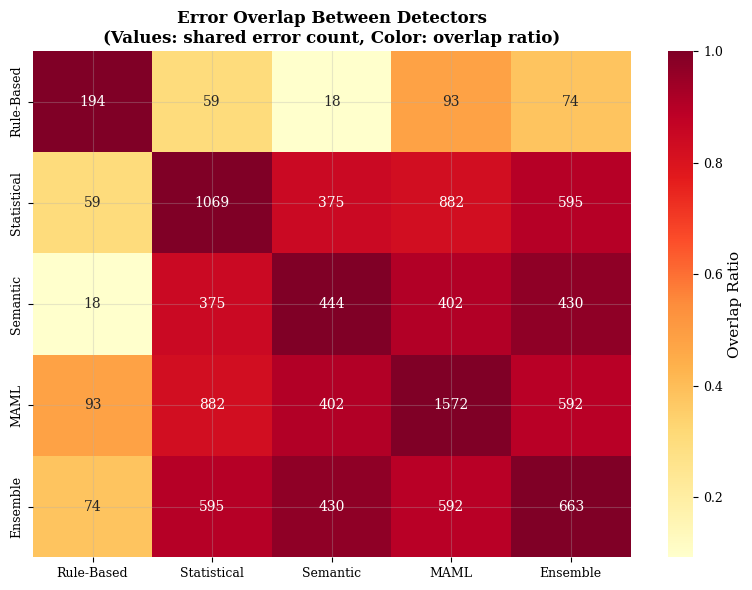

In [20]:
# Visualize error overlap
fig, ax = plt.subplots(figsize=(8, 6))

# Normalize by minimum errors between pairs (Jaccard-like)
overlap_normalized = np.zeros_like(overlap_matrix)
for i in range(len(detector_names)):
    for j in range(len(detector_names)):
        if i != j:
            min_errors = min(overlap_matrix[i, i], overlap_matrix[j, j])
            if min_errors > 0:
                overlap_normalized[i, j] = overlap_matrix[i, j] / min_errors
        else:
            overlap_normalized[i, j] = 1.0

labels = [DETECTOR_LABELS[n] for n in detector_names]

sns.heatmap(overlap_normalized, annot=overlap_matrix.astype(int), fmt='d',
            xticklabels=labels, yticklabels=labels,
            cmap='YlOrRd', ax=ax,
            cbar_kws={'label': 'Overlap Ratio'})

ax.set_title('Error Overlap Between Detectors\n(Values: shared error count, Color: overlap ratio)', 
             fontweight='bold')
plt.tight_layout()
plt.savefig('../figures/error_overlap_heatmap.png', dpi=600, bbox_inches='tight')
plt.show()

In [21]:
# Unique errors per detector (errors only that detector makes)
all_errors = set()
for name in detector_names:
    all_errors |= errors[name]

unique_errors = {}
for name in detector_names:
    other_errors = set()
    for other_name in detector_names:
        if other_name != name:
            other_errors |= errors[other_name]
    unique_errors[name] = errors[name] - other_errors

# Common errors (all detectors fail)
common_errors = errors[detector_names[0]].copy()
for name in detector_names[1:]:
    common_errors &= errors[name]

print("\nError Distribution Analysis")
print("=" * 50)
print(f"Total unique errors across all detectors: {len(all_errors)}")
print(f"Common errors (all detectors fail): {len(common_errors)}")
print(f"\nUnique errors per detector (only this detector fails):")
for name in detector_names:
    print(f"  {DETECTOR_LABELS[name]:<15}: {len(unique_errors[name])}")


Error Distribution Analysis
Total unique errors across all detectors: 1868
Common errors (all detectors fail): 7

Unique errors per detector (only this detector fails):
  Rule-Based     : 91
  Statistical    : 123
  Semantic       : 6
  MAML           : 605
  Ensemble       : 0


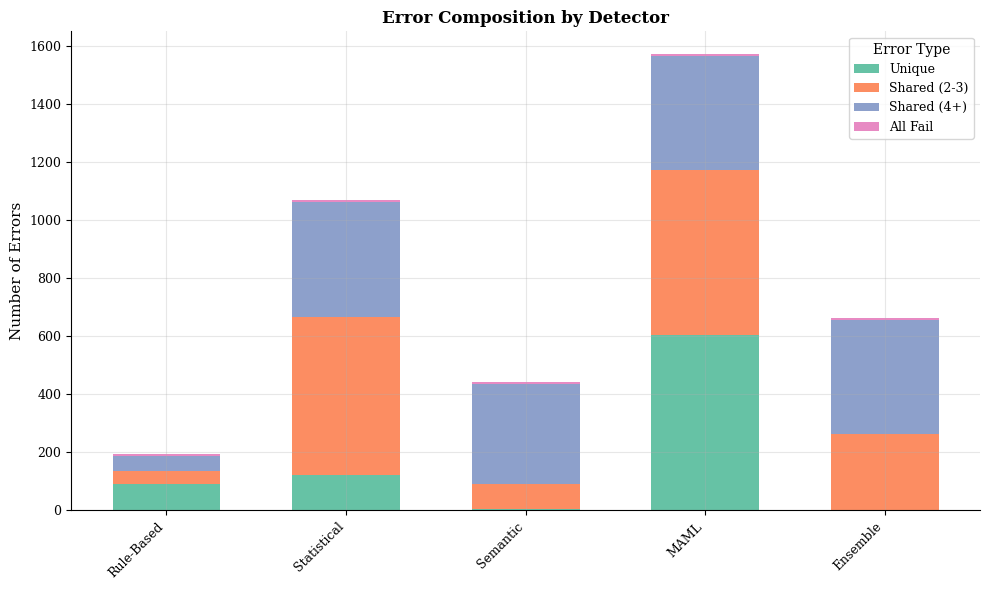

In [22]:
# Visualize error distribution
fig, ax = plt.subplots(figsize=(10, 6))

# Create stacked bar showing error composition
error_composition = []
categories = ['Unique', 'Shared (2-3)', 'Shared (4+)', 'All Fail']

for name in detector_names:
    unique = len(unique_errors[name])
    all_fail = len(common_errors & errors[name])
    
    # Shared with some but not all
    shared_some = 0
    shared_many = 0
    for err_idx in errors[name]:
        count = sum(1 for n in detector_names if err_idx in errors[n])
        if count == 2 or count == 3:
            shared_some += 1
        elif count >= 4 and err_idx not in common_errors:
            shared_many += 1
    
    error_composition.append([unique, shared_some, shared_many, all_fail])

error_composition = np.array(error_composition)
labels = [DETECTOR_LABELS[n] for n in detector_names]

x = np.arange(len(detector_names))
width = 0.6

colors_stack = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']
bottom = np.zeros(len(detector_names))

for i, (cat, color) in enumerate(zip(categories, colors_stack)):
    ax.bar(x, error_composition[:, i], width, bottom=bottom, label=cat, color=color)
    bottom += error_composition[:, i]

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Number of Errors')
ax.set_title('Error Composition by Detector', fontweight='bold')
ax.legend(title='Error Type', loc='upper right')

plt.tight_layout()
plt.savefig('../figures/error_composition.png', dpi=600, bbox_inches='tight')
plt.show()

### 7.2 Error Type Analysis (FP vs FN)

In [23]:
# Analyze false positives and false negatives for each detector
error_types = {}

for name in detector_names:
    preds = results[name].predictions
    
    # False positives: predicted attack (1) but actually benign (0)
    fp_indices = np.where((preds == 1) & (y_true == 0))[0]
    # False negatives: predicted benign (0) but actually attack (1)
    fn_indices = np.where((preds == 0) & (y_true == 1))[0]
    
    error_types[name] = {
        'fp': len(fp_indices),
        'fn': len(fn_indices),
        'fp_rate': len(fp_indices) / sum(y_true == 0) if sum(y_true == 0) > 0 else 0,
        'fn_rate': len(fn_indices) / sum(y_true == 1) if sum(y_true == 1) > 0 else 0,
        'fp_indices': fp_indices,
        'fn_indices': fn_indices
    }

print("False Positive / False Negative Analysis")
print("=" * 60)
print(f"{'Detector':<15} {'FP':>6} {'FN':>6} {'FP Rate':>10} {'FN Rate':>10}")
print("-" * 60)

for name in detector_names:
    et = error_types[name]
    print(f"{DETECTOR_LABELS[name]:<15} {et['fp']:>6} {et['fn']:>6} "
          f"{et['fp_rate']:>10.2%} {et['fn_rate']:>10.2%}")

print("-" * 60)
print(f"Total Benign: {sum(y_true == 0)}, Total Attack: {sum(y_true == 1)}")

False Positive / False Negative Analysis
Detector            FP     FN    FP Rate    FN Rate
------------------------------------------------------------
Rule-Based          81    113      3.88%     47.08%
Statistical       1062      7     50.86%      2.92%
Semantic           427     17     20.45%      7.08%
MAML              1552     20     74.33%      8.33%
Ensemble           657      6     31.47%      2.50%
------------------------------------------------------------
Total Benign: 2088, Total Attack: 240


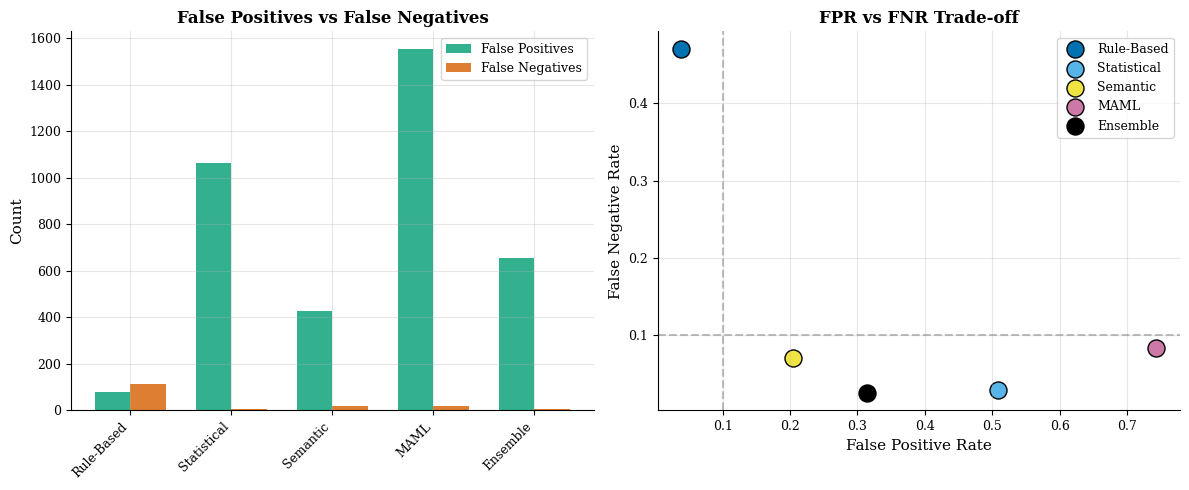

In [24]:
# Visualize FP/FN trade-off
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar chart of FP/FN counts
ax = axes[0]
x = np.arange(len(detector_names))
width = 0.35

fp_counts = [error_types[n]['fp'] for n in detector_names]
fn_counts = [error_types[n]['fn'] for n in detector_names]

ax.bar(x - width/2, fp_counts, width, label='False Positives', color=COLORS['benign'], alpha=0.8)
ax.bar(x + width/2, fn_counts, width, label='False Negatives', color=COLORS['attack'], alpha=0.8)

ax.set_xticks(x)
ax.set_xticklabels([DETECTOR_LABELS[n] for n in detector_names], rotation=45, ha='right')
ax.set_ylabel('Count')
ax.set_title('False Positives vs False Negatives', fontweight='bold')
ax.legend()

# Scatter plot of FP rate vs FN rate
ax = axes[1]

for name in detector_names:
    et = error_types[name]
    ax.scatter(et['fp_rate'], et['fn_rate'], 
               s=150, c=COLORS[name], label=DETECTOR_LABELS[name],
               edgecolors='black', linewidth=1)

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('False Negative Rate')
ax.set_title('FPR vs FNR Trade-off', fontweight='bold')
ax.legend()

# Add quadrant labels
ax.axhline(y=0.1, color='gray', linestyle='--', alpha=0.5)
ax.axvline(x=0.1, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('../figures/fp_fn_analysis.png', dpi=600, bbox_inches='tight')
plt.show()

---

## 8. Prediction Agreement Analysis

### 8.1 Prediction Correlation Matrix

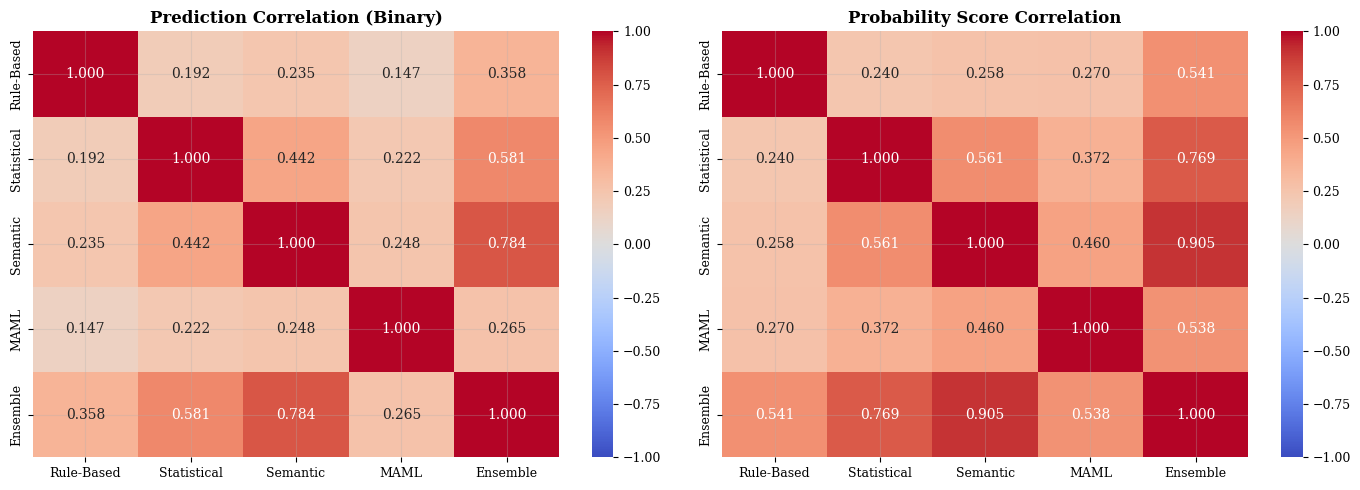

In [25]:
# Build prediction matrix
pred_matrix = np.column_stack([results[n].predictions for n in detector_names])
prob_matrix = np.column_stack([results[n].probabilities for n in detector_names])

# Correlation of predictions (binary)
pred_corr = np.corrcoef(pred_matrix.T)

# Correlation of probabilities (continuous)
prob_corr = np.corrcoef(prob_matrix.T)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Binary prediction correlation
labels = [DETECTOR_LABELS[n] for n in detector_names]
sns.heatmap(pred_corr, annot=True, fmt='.3f', cmap='coolwarm',
            xticklabels=labels, yticklabels=labels,
            ax=axes[0], center=0, vmin=-1, vmax=1)
axes[0].set_title('Prediction Correlation (Binary)', fontweight='bold')

# Probability correlation
sns.heatmap(prob_corr, annot=True, fmt='.3f', cmap='coolwarm',
            xticklabels=labels, yticklabels=labels,
            ax=axes[1], center=0, vmin=-1, vmax=1)
axes[1].set_title('Probability Score Correlation', fontweight='bold')

plt.tight_layout()
plt.savefig('../figures/prediction_correlation.png', dpi=600, bbox_inches='tight')
plt.show()

### 8.2 Agreement Analysis

In [26]:
# Count how many detectors agree on each sample
n_individual = len(detector_names) - 1  # Exclude ensemble
individual_names = [n for n in detector_names if n != 'ensemble']

individual_preds = np.column_stack([results[n].predictions for n in individual_names])

# Count votes for attack (1)
attack_votes = individual_preds.sum(axis=1)

# Agreement level: how many agree (out of n_individual)
agreement_levels = np.maximum(attack_votes, n_individual - attack_votes)

print("Detector Agreement Distribution")
print("=" * 50)
for level in range(n_individual + 1):
    count = np.sum(agreement_levels == level)
    pct = count / len(agreement_levels) * 100
    print(f"  {level}/{n_individual} agree: {count:>5} samples ({pct:>5.1f}%)")

# Unanimous vs split decisions
unanimous = np.sum(agreement_levels == n_individual)
split = len(agreement_levels) - unanimous

print(f"\nUnanimous decisions: {unanimous} ({unanimous/len(agreement_levels)*100:.1f}%)")
print(f"Split decisions: {split} ({split/len(agreement_levels)*100:.1f}%)")

Detector Agreement Distribution
  0/4 agree:     0 samples (  0.0%)
  1/4 agree:     0 samples (  0.0%)
  2/4 agree:   596 samples ( 25.6%)
  3/4 agree:  1265 samples ( 54.3%)
  4/4 agree:   467 samples ( 20.1%)

Unanimous decisions: 467 (20.1%)
Split decisions: 1861 (79.9%)


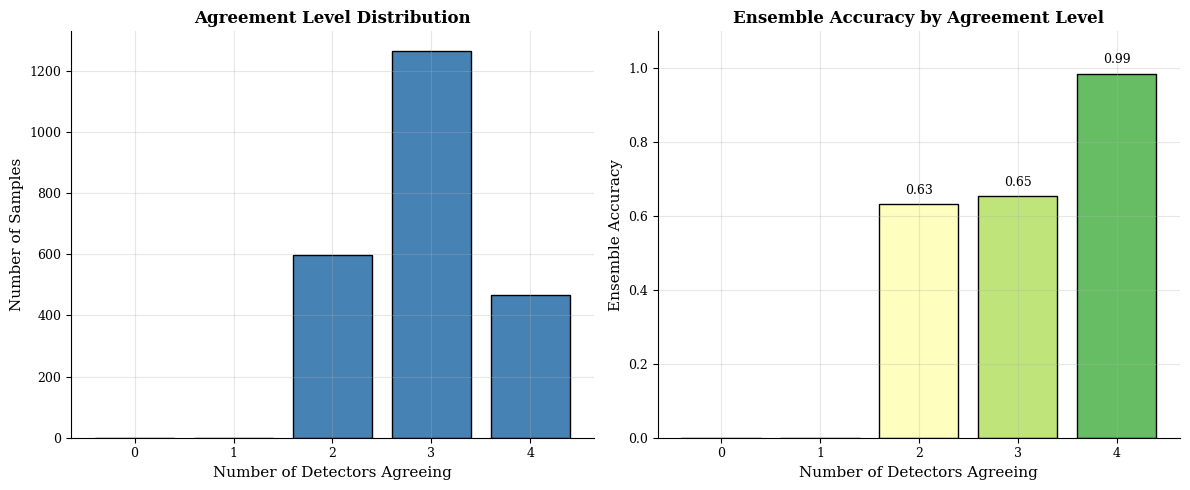

In [27]:
# Analyze accuracy by agreement level
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Agreement distribution
ax = axes[0]
agreement_counts = [np.sum(agreement_levels == i) for i in range(n_individual + 1)]
ax.bar(range(n_individual + 1), agreement_counts, color='steelblue', edgecolor='black')
ax.set_xlabel('Number of Detectors Agreeing')
ax.set_ylabel('Number of Samples')
ax.set_title('Agreement Level Distribution', fontweight='bold')
ax.set_xticks(range(n_individual + 1))

# Accuracy by agreement level
ax = axes[1]
accuracy_by_agreement = []
ensemble_preds = results['ensemble'].predictions

for level in range(n_individual + 1):
    mask = agreement_levels == level
    if mask.sum() > 0:
        acc = accuracy_score(y_true[mask], ensemble_preds[mask])
        accuracy_by_agreement.append(acc)
    else:
        accuracy_by_agreement.append(0)

colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, n_individual + 1))
ax.bar(range(n_individual + 1), accuracy_by_agreement, color=colors, edgecolor='black')
ax.set_xlabel('Number of Detectors Agreeing')
ax.set_ylabel('Ensemble Accuracy')
ax.set_title('Ensemble Accuracy by Agreement Level', fontweight='bold')
ax.set_xticks(range(n_individual + 1))
ax.set_ylim(0, 1.1)

# Add value labels
for i, (acc, count) in enumerate(zip(accuracy_by_agreement, agreement_counts)):
    if count > 0:
        ax.text(i, acc + 0.02, f'{acc:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../figures/agreement_analysis.png', dpi=600, bbox_inches='tight')
plt.show()

### 8.3 Cohen's Kappa Agreement

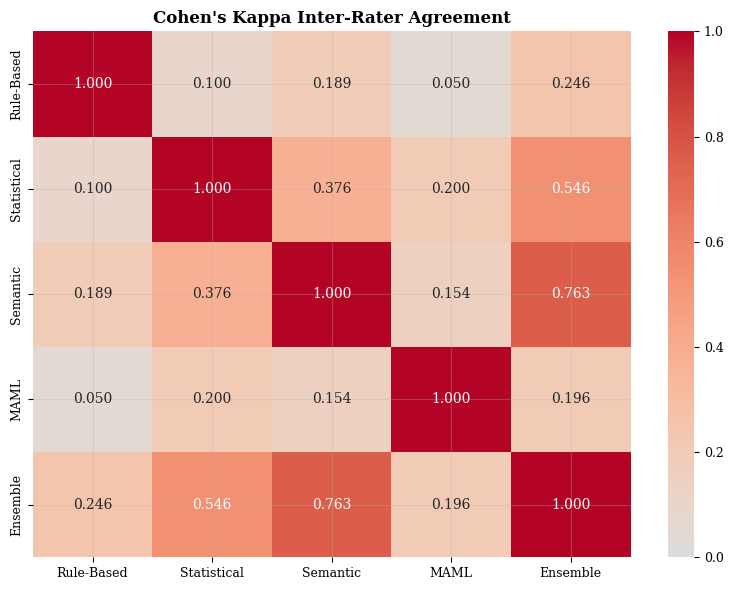


Kappa Interpretation Guide:
  < 0.20: Poor
  0.21-0.40: Fair
  0.41-0.60: Moderate
  0.61-0.80: Substantial
  0.81-1.00: Almost Perfect


In [28]:
# Pairwise Cohen's Kappa (inter-rater agreement)
kappa_matrix = np.zeros((len(detector_names), len(detector_names)))

for i, name_a in enumerate(detector_names):
    for j, name_b in enumerate(detector_names):
        kappa = cohen_kappa_score(results[name_a].predictions, results[name_b].predictions)
        kappa_matrix[i, j] = kappa

fig, ax = plt.subplots(figsize=(8, 6))

labels = [DETECTOR_LABELS[n] for n in detector_names]
sns.heatmap(kappa_matrix, annot=True, fmt='.3f', cmap='coolwarm',
            xticklabels=labels, yticklabels=labels,
            ax=ax, center=0, vmin=0, vmax=1)

ax.set_title("Cohen's Kappa Inter-Rater Agreement", fontweight='bold')
plt.tight_layout()
plt.savefig('../figures/kappa_agreement.png', dpi=600, bbox_inches='tight')
plt.show()

print("\nKappa Interpretation Guide:")
print("  < 0.20: Poor")
print("  0.21-0.40: Fair")
print("  0.41-0.60: Moderate")
print("  0.61-0.80: Substantial")
print("  0.81-1.00: Almost Perfect")

---

## 9. Computational Efficiency Comparison

### 9.1 Latency Analysis

In [29]:
# Latency statistics
latency_stats = {}

print("Inference Latency Statistics (ms)")
print("=" * 70)
print(f"{'Detector':<15} {'Mean':>10} {'Std':>10} {'P50':>10} {'P95':>10} {'P99':>10}")
print("-" * 70)

for name in detector_names:
    if name == 'ensemble':
        continue  # Skip ensemble (sum of others)
    
    latencies = results[name].latencies
    stats_dict = {
        'mean': np.mean(latencies),
        'std': np.std(latencies),
        'p50': np.percentile(latencies, 50),
        'p95': np.percentile(latencies, 95),
        'p99': np.percentile(latencies, 99),
        'min': np.min(latencies),
        'max': np.max(latencies)
    }
    latency_stats[name] = stats_dict
    
    print(f"{DETECTOR_LABELS[name]:<15} {stats_dict['mean']:>10.2f} {stats_dict['std']:>10.2f} "
          f"{stats_dict['p50']:>10.2f} {stats_dict['p95']:>10.2f} {stats_dict['p99']:>10.2f}")

# Ensemble total
ensemble_lat = results['ensemble'].latencies
print("-" * 70)
print(f"{'Ensemble (sum)':<15} {np.mean(ensemble_lat):>10.2f} {np.std(ensemble_lat):>10.2f} "
      f"{np.percentile(ensemble_lat, 50):>10.2f} {np.percentile(ensemble_lat, 95):>10.2f} "
      f"{np.percentile(ensemble_lat, 99):>10.2f}")

Inference Latency Statistics (ms)
Detector              Mean        Std        P50        P95        P99
----------------------------------------------------------------------
Rule-Based            0.03       0.01       0.03       0.04       0.05
Statistical           0.06       0.02       0.06       0.08       0.09
Semantic             17.75       6.35      16.32      25.72      36.65
MAML                  6.94       4.63       6.41       9.53      10.48
----------------------------------------------------------------------
Ensemble (sum)       24.79       8.17      23.29      33.14      44.76


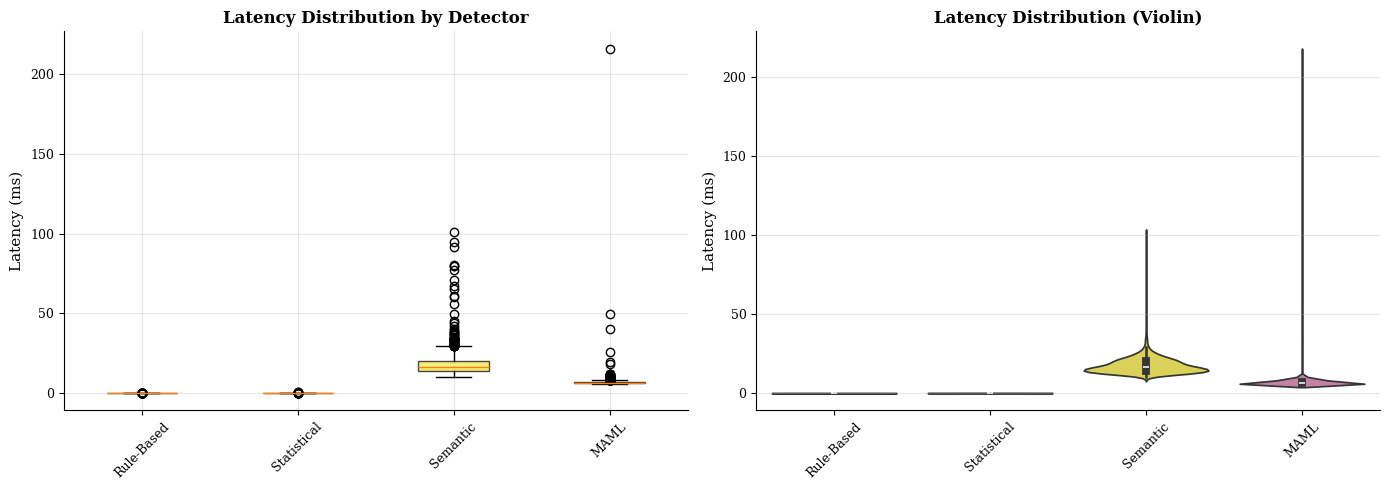

In [30]:
# Latency distribution visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
ax = axes[0]
latency_data = [results[n].latencies for n in detector_names if n != 'ensemble']
labels = [DETECTOR_LABELS[n] for n in detector_names if n != 'ensemble']
colors = [COLORS[n] for n in detector_names if n != 'ensemble']

bp = ax.boxplot(latency_data, labels=labels, patch_artist=True)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel('Latency (ms)')
ax.set_title('Latency Distribution by Detector', fontweight='bold')
ax.tick_params(axis='x', rotation=45)

# Violin plot with log scale
ax = axes[1]
latency_df = pd.DataFrame({
    DETECTOR_LABELS[n]: results[n].latencies 
    for n in detector_names if n != 'ensemble'
})

sns.violinplot(data=latency_df, ax=ax, palette=[COLORS[n] for n in detector_names if n != 'ensemble'])
ax.set_ylabel('Latency (ms)')
ax.set_title('Latency Distribution (Violin)', fontweight='bold')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../figures/latency_distribution.png', dpi=600, bbox_inches='tight')
plt.show()

### 9.2 Performance vs Latency Trade-off

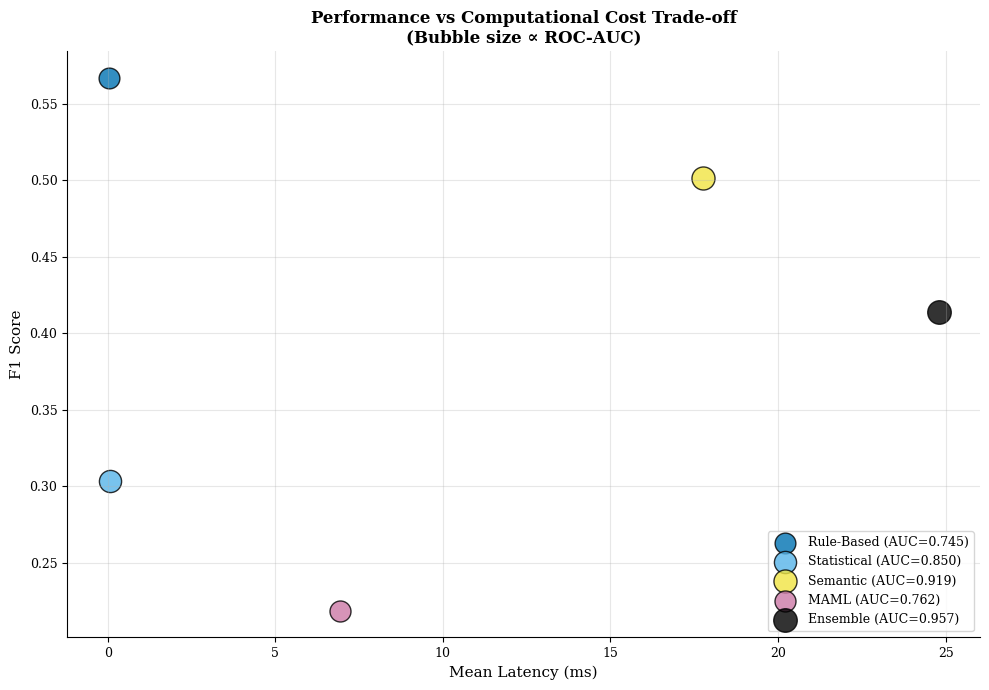

In [31]:
# Scatter plot: F1 vs Mean Latency
fig, ax = plt.subplots(figsize=(10, 7))

for name in detector_names:
    if name == 'ensemble':
        latency = np.mean(results[name].latencies)
    else:
        latency = latency_stats[name]['mean']
    
    f1 = all_metrics[name]['f1']
    auc_score = all_metrics[name]['roc_auc']
    
    # Size proportional to AUC
    size = auc_score * 300
    
    ax.scatter(latency, f1, s=size, c=COLORS[name], 
               label=f"{DETECTOR_LABELS[name]} (AUC={auc_score:.3f})",
               edgecolors='black', linewidth=1, alpha=0.8)

ax.set_xlabel('Mean Latency (ms)')
ax.set_ylabel('F1 Score')
ax.set_title('Performance vs Computational Cost Trade-off\n(Bubble size ∝ ROC-AUC)', fontweight='bold')
ax.legend(loc='lower right')

# Add Pareto frontier
pareto_points = []
for name in detector_names:
    if name == 'ensemble':
        lat = np.mean(results[name].latencies)
    else:
        lat = latency_stats[name]['mean']
    pareto_points.append((lat, all_metrics[name]['f1'], name))

# Sort by latency
pareto_points.sort(key=lambda x: x[0])

# Find Pareto optimal points
pareto_optimal = []
max_f1 = -1
for lat, f1, name in pareto_points:
    if f1 > max_f1:
        pareto_optimal.append((lat, f1))
        max_f1 = f1

if len(pareto_optimal) > 1:
    pareto_x, pareto_y = zip(*pareto_optimal)
    ax.plot(pareto_x, pareto_y, 'k--', alpha=0.5, label='Pareto Frontier')

plt.tight_layout()
plt.savefig('../figures/performance_latency_tradeoff.png', dpi=600, bbox_inches='tight')
plt.show()

### 9.3 Throughput Analysis

Throughput Analysis
Rule-Based     :  34043.0 samples/sec
Statistical    :  16392.6 samples/sec
Semantic       :     56.3 samples/sec
MAML           :    144.0 samples/sec
Ensemble       :     40.3 samples/sec


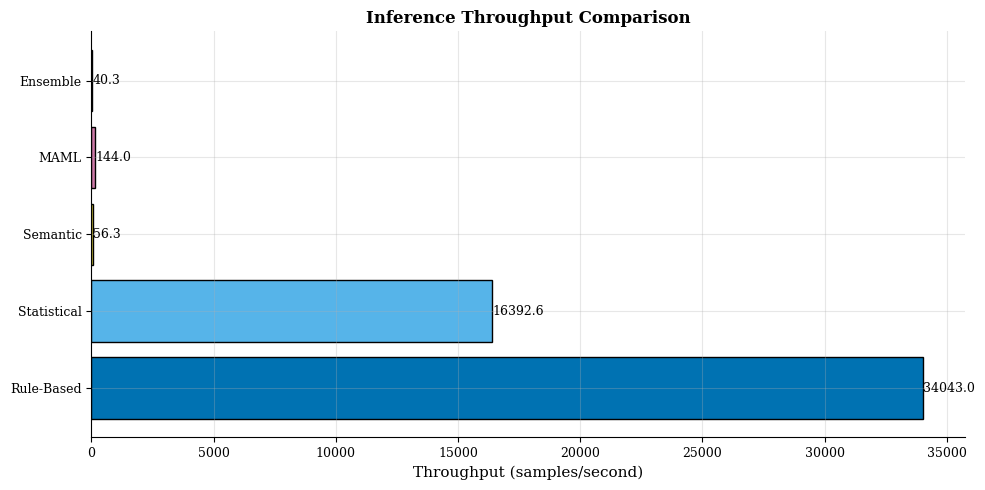

In [32]:
# Calculate throughput (samples per second)
print("Throughput Analysis")
print("=" * 50)

throughput = {}
for name in detector_names:
    if name == 'ensemble':
        mean_lat = np.mean(results[name].latencies)
    else:
        mean_lat = latency_stats[name]['mean']
    
    samples_per_sec = 1000 / mean_lat  # Convert ms to samples/sec
    throughput[name] = samples_per_sec
    print(f"{DETECTOR_LABELS[name]:<15}: {samples_per_sec:>8.1f} samples/sec")

# Visualize throughput
fig, ax = plt.subplots(figsize=(10, 5))

names = list(throughput.keys())
values = list(throughput.values())
colors_list = [COLORS[n] for n in names]

bars = ax.barh([DETECTOR_LABELS[n] for n in names], values, color=colors_list, edgecolor='black')

ax.set_xlabel('Throughput (samples/second)')
ax.set_title('Inference Throughput Comparison', fontweight='bold')

# Add value labels
for bar, val in zip(bars, values):
    ax.text(val + 5, bar.get_y() + bar.get_height()/2, f'{val:.1f}',
            va='center', fontsize=9)

plt.tight_layout()
plt.savefig('../figures/throughput_comparison.png', dpi=600, bbox_inches='tight')
plt.show()

---

## 10. Per-Tool Performance Comparison

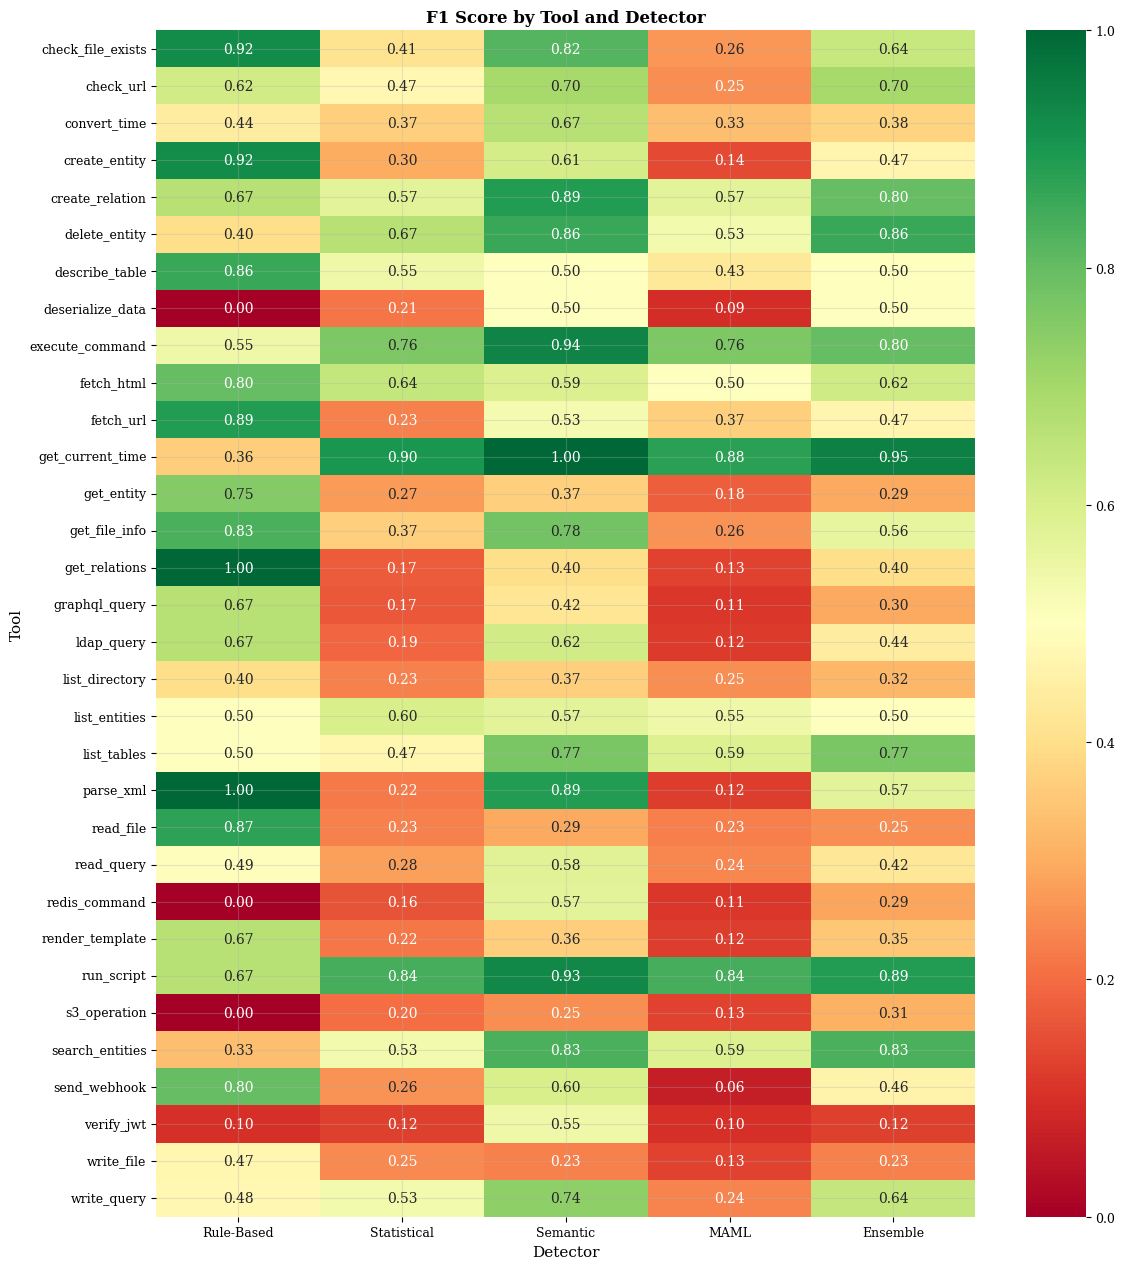

In [33]:
# Compute F1 score per tool for each detector
unique_tools = sorted(set(test_tools))
tool_metrics = {name: {} for name in detector_names}

for tool in unique_tools:
    tool_mask = np.array([t == tool for t in test_tools])
    tool_y_true = y_true[tool_mask]
    
    # Skip tools with only one class
    if len(np.unique(tool_y_true)) < 2:
        continue
    
    for name in detector_names:
        tool_y_pred = results[name].predictions[tool_mask]
        tool_metrics[name][tool] = {
            'f1': f1_score(tool_y_true, tool_y_pred, zero_division=0),
            'precision': precision_score(tool_y_true, tool_y_pred, zero_division=0),
            'recall': recall_score(tool_y_true, tool_y_pred, zero_division=0),
            'n_samples': len(tool_y_true)
        }

# Create comparison heatmap
tools_with_metrics = list(tool_metrics[detector_names[0]].keys())

f1_matrix = np.zeros((len(tools_with_metrics), len(detector_names)))
for i, tool in enumerate(tools_with_metrics):
    for j, name in enumerate(detector_names):
        f1_matrix[i, j] = tool_metrics[name][tool]['f1']

fig, ax = plt.subplots(figsize=(12, max(8, len(tools_with_metrics) * 0.4)))

sns.heatmap(f1_matrix, annot=True, fmt='.2f', cmap='RdYlGn',
            xticklabels=[DETECTOR_LABELS[n] for n in detector_names],
            yticklabels=tools_with_metrics,
            ax=ax, vmin=0, vmax=1)

ax.set_title('F1 Score by Tool and Detector', fontweight='bold')
ax.set_xlabel('Detector')
ax.set_ylabel('Tool')

plt.tight_layout()
plt.savefig('../figures/per_tool_f1_heatmap.png', dpi=600, bbox_inches='tight')
plt.show()

In [34]:
# Identify best detector per tool
print("Best Detector per Tool")
print("=" * 60)
print(f"{'Tool':<25} {'Best Detector':<15} {'F1 Score':>10}")
print("-" * 60)

best_counts = {name: 0 for name in detector_names}

for tool in tools_with_metrics:
    best_f1 = -1
    best_detector = None
    
    for name in detector_names:
        f1 = tool_metrics[name][tool]['f1']
        if f1 > best_f1:
            best_f1 = f1
            best_detector = name
    
    best_counts[best_detector] += 1
    print(f"{tool:<25} {DETECTOR_LABELS[best_detector]:<15} {best_f1:>10.3f}")

print("-" * 60)
print("\nSummary - Number of tools where each detector is best:")
for name, count in sorted(best_counts.items(), key=lambda x: -x[1]):
    print(f"  {DETECTOR_LABELS[name]:<15}: {count} tools")

Best Detector per Tool
Tool                      Best Detector     F1 Score
------------------------------------------------------------
check_file_exists         Rule-Based           0.923
check_url                 Semantic             0.696
convert_time              Semantic             0.667
create_entity             Rule-Based           0.923
create_relation           Semantic             0.889
delete_entity             Semantic             0.857
describe_table            Rule-Based           0.857
deserialize_data          Semantic             0.500
execute_command           Semantic             0.941
fetch_html                Rule-Based           0.800
fetch_url                 Rule-Based           0.889
get_current_time          Semantic             1.000
get_entity                Rule-Based           0.750
get_file_info             Rule-Based           0.833
get_relations             Rule-Based           1.000
graphql_query             Rule-Based           0.667
ldap_query     

---

## 11. Summary and Recommendations

In [35]:
# Generate final summary table
summary_data = []

for name in detector_names:
    row = {
        'Detector': DETECTOR_LABELS[name],
        'ROC-AUC': all_metrics[name]['roc_auc'],
        'F1': all_metrics[name]['f1'],
        'Precision': all_metrics[name]['precision'],
        'Recall': all_metrics[name]['recall'],
        'MCC': all_metrics[name]['mcc'],
        'FP Count': error_types[name]['fp'],
        'FN Count': error_types[name]['fn'],
        'Mean Latency (ms)': np.mean(results[name].latencies),
        'Throughput (samples/s)': throughput[name]
    }
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.set_index('Detector')

print("=" * 100)
print("FINAL MODEL COMPARISON SUMMARY")
print("=" * 100)
display(summary_df.round(4))

FINAL MODEL COMPARISON SUMMARY


,ROC-AUC,F1,Precision,Recall,MCC,FP Count,FN Count,Mean Latency (ms),Throughput (samples/s)
Detector,,,,,,,,,
Rule-Based,0.7452,0.5670,0.6106,0.5292,0.5228,81,113,0.0294,34043.0012
Statistical,0.8504,0.3036,0.1799,0.9708,0.2829,1062,7,0.0610,16392.5538
Semantic,0.9188,0.5011,0.3431,0.9292,0.4912,427,17,17.7532,56.3278
MAML,0.7619,0.2187,0.1242,0.9167,0.1236,1552,20,6.9429,144.0323
Ensemble,0.9565,0.4138,0.2626,0.9750,0.4131,657,6,24.7865,40.3446


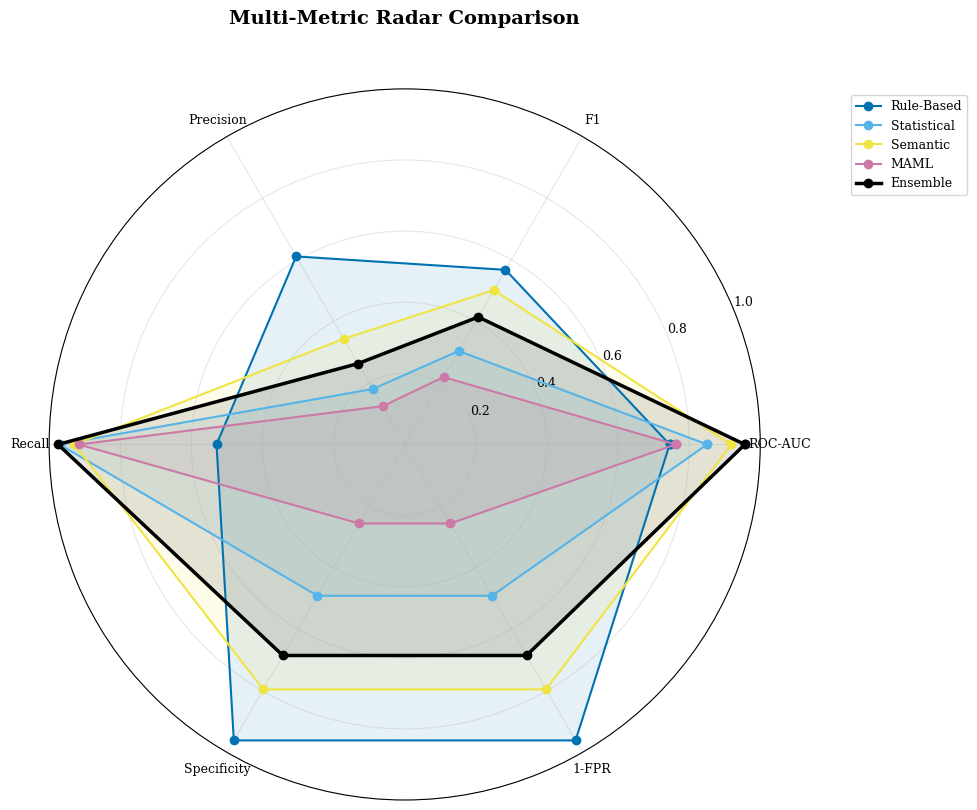

In [36]:
# Radar chart comparison
def create_radar_chart(metrics_dict: Dict, detector_names: List[str]):
    """Create radar chart comparing detectors across multiple metrics."""
    categories = ['ROC-AUC', 'F1', 'Precision', 'Recall', 'Specificity', '1-FPR']
    
    # Compute values for each detector
    values_dict = {}
    for name in detector_names:
        m = metrics_dict[name]
        values_dict[name] = [
            m['roc_auc'],
            m['f1'],
            m['precision'],
            m['recall'],
            m['specificity'],
            1 - error_types[name]['fp_rate']
        ]
    
    # Number of variables
    N = len(categories)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the polygon
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    for name in detector_names:
        values = values_dict[name] + values_dict[name][:1]
        
        linewidth = 2.5 if name == 'ensemble' else 1.5
        ax.plot(angles, values, 'o-', linewidth=linewidth, 
                label=DETECTOR_LABELS[name], color=COLORS[name])
        ax.fill(angles, values, alpha=0.1, color=COLORS[name])
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_ylim(0, 1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    ax.set_title('Multi-Metric Radar Comparison', fontweight='bold', size=14, y=1.08)
    
    return fig

fig = create_radar_chart(all_metrics, detector_names)
plt.tight_layout()
plt.savefig('../figures/radar_comparison.png', dpi=600, bbox_inches='tight')
plt.show()

In [37]:
# Final ranking
print("\n" + "=" * 80)
print("DETECTOR RANKINGS")
print("=" * 80)

# Rank by different metrics
rankings = {}

for metric in ['roc_auc', 'f1', 'precision', 'recall', 'mcc']:
    sorted_detectors = sorted(detector_names, key=lambda x: all_metrics[x][metric], reverse=True)
    rankings[metric] = sorted_detectors
    
    print(f"\nBy {metric.upper()}:")
    for i, name in enumerate(sorted_detectors, 1):
        print(f"  {i}. {DETECTOR_LABELS[name]:<15} ({all_metrics[name][metric]:.4f})")

# Compute average rank
avg_ranks = {name: 0 for name in detector_names}
for metric, ranking in rankings.items():
    for i, name in enumerate(ranking):
        avg_ranks[name] += i + 1

for name in avg_ranks:
    avg_ranks[name] /= len(rankings)

print("\n" + "-" * 40)
print("OVERALL RANKING (Average across metrics):")
print("-" * 40)

for i, (name, rank) in enumerate(sorted(avg_ranks.items(), key=lambda x: x[1]), 1):
    print(f"  {i}. {DETECTOR_LABELS[name]:<15} (avg rank: {rank:.2f})")


DETECTOR RANKINGS

By ROC_AUC:
  1. Ensemble        (0.9565)
  2. Semantic        (0.9188)
  3. Statistical     (0.8504)
  4. MAML            (0.7619)
  5. Rule-Based      (0.7452)

By F1:
  1. Rule-Based      (0.5670)
  2. Semantic        (0.5011)
  3. Ensemble        (0.4138)
  4. Statistical     (0.3036)
  5. MAML            (0.2187)

By PRECISION:
  1. Rule-Based      (0.6106)
  2. Semantic        (0.3431)
  3. Ensemble        (0.2626)
  4. Statistical     (0.1799)
  5. MAML            (0.1242)

By RECALL:
  1. Ensemble        (0.9750)
  2. Statistical     (0.9708)
  3. Semantic        (0.9292)
  4. MAML            (0.9167)
  5. Rule-Based      (0.5292)

By MCC:
  1. Rule-Based      (0.5228)
  2. Semantic        (0.4912)
  3. Ensemble        (0.4131)
  4. Statistical     (0.2829)
  5. MAML            (0.1236)

----------------------------------------
OVERALL RANKING (Average across metrics):
----------------------------------------
  1. Semantic        (avg rank: 2.20)
  2. Ensemb

In [38]:
# Key findings summary
print("\n" + "=" * 80)
print("KEY FINDINGS")
print("=" * 80)

# Best overall performer
best_overall = min(avg_ranks.items(), key=lambda x: x[1])[0]
print(f"\n1. BEST OVERALL PERFORMER: {DETECTOR_LABELS[best_overall]}")
print(f"   - ROC-AUC: {all_metrics[best_overall]['roc_auc']:.4f}")
print(f"   - F1 Score: {all_metrics[best_overall]['f1']:.4f}")

# Fastest detector
fastest = min([n for n in detector_names if n != 'ensemble'], 
              key=lambda x: latency_stats[x]['mean'])
print(f"\n2. FASTEST DETECTOR: {DETECTOR_LABELS[fastest]}")
print(f"   - Mean latency: {latency_stats[fastest]['mean']:.2f} ms")
print(f"   - Throughput: {throughput[fastest]:.1f} samples/sec")

# Ensemble value
individual_best_auc = max(all_metrics[n]['roc_auc'] for n in detector_names if n != 'ensemble')
ensemble_auc = all_metrics['ensemble']['roc_auc']
ensemble_gain = ensemble_auc - individual_best_auc

print(f"\n3. ENSEMBLE VALUE:")
if ensemble_gain > 0:
    print(f"   - Ensemble improves over best individual by {ensemble_gain:.4f} AUC points")
else:
    print(f"   - Ensemble does not improve over best individual ({ensemble_gain:.4f} AUC)")

# Complementarity
print(f"\n4. DETECTOR COMPLEMENTARITY:")
print(f"   - Common errors (all detectors fail): {len(common_errors)} samples")
print(f"   - Total unique errors across all: {len(all_errors)} samples")
print(f"   - Error diversity ratio: {1 - len(common_errors)/len(all_errors):.2%}")

# Statistical significance
sig_pairs = sum(1 for i in range(len(detector_names)) 
                for j in range(i+1, len(detector_names)) 
                if mcnemar_matrix[i, j] < 0.05)
total_pairs = len(detector_names) * (len(detector_names) - 1) // 2

print(f"\n5. STATISTICAL SIGNIFICANCE:")
print(f"   - {sig_pairs}/{total_pairs} detector pairs significantly different (p<0.05)")


KEY FINDINGS

1. BEST OVERALL PERFORMER: Semantic
   - ROC-AUC: 0.9188
   - F1 Score: 0.5011

2. FASTEST DETECTOR: Rule-Based
   - Mean latency: 0.03 ms
   - Throughput: 34043.0 samples/sec

3. ENSEMBLE VALUE:
   - Ensemble improves over best individual by 0.0377 AUC points

4. DETECTOR COMPLEMENTARITY:
   - Common errors (all detectors fail): 7 samples
   - Total unique errors across all: 1868 samples
   - Error diversity ratio: 99.63%

5. STATISTICAL SIGNIFICANCE:
   - 10/10 detector pairs significantly different (p<0.05)


In [39]:
# Export results
output_dir = Path('../evaluation_results')
output_dir.mkdir(exist_ok=True)

# Save summary table
summary_df.to_csv(output_dir / 'model_comparison_summary.csv')

# Save detailed metrics
metrics_export = pd.DataFrame(all_metrics).T
metrics_export.to_csv(output_dir / 'detailed_metrics.csv')

# Save McNemar results
mcnemar_df = pd.DataFrame(mcnemar_matrix, 
                          index=[DETECTOR_LABELS[n] for n in detector_names],
                          columns=[DETECTOR_LABELS[n] for n in detector_names])
mcnemar_df.to_csv(output_dir / 'mcnemar_pvalues.csv')

print(f"\nResults exported to {output_dir}/")
print("  - model_comparison_summary.csv")
print("  - detailed_metrics.csv")
print("  - mcnemar_pvalues.csv")


Results exported to ..\evaluation_results/
  - model_comparison_summary.csv
  - detailed_metrics.csv
  - mcnemar_pvalues.csv


---

## 12. Conclusions

This comparative analysis evaluated five detection models across multiple dimensions:

### Performance
- **ROC-AUC** and **F1 scores** provide overall discrimination ability
- **Precision/Recall trade-offs** reveal detector biases toward FP or FN
- **Per-tool analysis** shows performance variation across different attack surfaces

### Statistical Rigor
- **McNemar's test** identifies statistically significant differences between detector pairs
- **Bootstrap confidence intervals** quantify uncertainty in metric estimates
- **Friedman test** provides multi-model ranking with critical difference analysis

### Error Analysis
- **Error overlap** reveals whether detectors make similar or complementary mistakes
- **FP/FN analysis** helps understand security vs usability trade-offs
- **Unique errors** identify samples only one detector misclassifies

### Computational Efficiency
- **Latency profiles** show inference speed characteristics
- **Throughput metrics** indicate real-world deployment capacity
- **Performance-latency trade-off** guides model selection for specific use cases

### Ensemble Value
- Ensemble combines strengths of individual detectors through weighted voting
- Fail-safe behavior (margin threshold) prioritizes security over permissiveness
- Detector diversity contributes to ensemble robustness

---

*Analysis completed. All figures saved to `figures/` directory.*